# Import Packages and Define Basic functions

In [1]:
%pylab notebook

import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
import os
import time
from scipy.optimize import curve_fit
from IPython.core.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
# display(HTML("<style>.container { width:85% !important; }</style>"))
from operator import itemgetter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# from __future__ import division, print_function
from scipy.spatial.distance import pdist, squareform

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.max_open_warning'] = False 
rcParams.update({'figure.autolayout': True})


    
# ----- Common Parameters in Plotting -----
w = 12           # width of figure
h = 4.5          # height of figure
Norm = True      # Normalize Data
timebin = 10000  # Timebin size
minFit = 3       # First data point to fit from
maxFit = 50      # Last data point to fit from

Populating the interactive namespace from numpy and matplotlib


In [2]:
# ----- Helper Functions -----
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def func_powerlaw(x, m, c):
    return x**m * c

def func_logNonlinPowLaw(s,a,m,sig,eps):
    powerlaw = a - m * s - eps * exp(sig*s)
    return powerlaw

def rec_plot(s, eps, steps=1):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = 1 - squareform(d)
    return Z

def logbinning(inputDurations,sizebin,divisor,maxim):
    """ Input: inputSizes - Array to logbin
               sizebin - number of bins 
    """
    ss = 0
    frequenciesDurationsUnormed = inputDurations[0].astype(float)
    for qwer in range(len(frequenciesDurationsUnormed[:,0])):
        frequenciesDurationsUnormed[qwer,0] = frequenciesDurationsUnormed[qwer,0]/divisor
    y_max = np.max(frequenciesDurationsUnormed[:,0])+1
    y_max = maxim
    rawLogBinEdges = np.logspace(0,np.log10(y_max)+1,sizebin)
    logBinEdges = np.array(list(set([int(i) for i in rawLogBinEdges])))
    logBinEdges = np.sort(logBinEdges)
    # print(y_max,logBinEdges)
    dbins = logBinEdges[1:]-logBinEdges[:-1]
    dbins = np.array([dbins[i] if dbins[i] != 0 else 1 for i in range(len(dbins))])
    frequenciesDurationsUnbinnedList = [[dbins[ss],0]]
    for j in range(len(frequenciesDurationsUnormed[:,0])):
        if int(frequenciesDurationsUnormed[j,0]) <= dbins[ss]:
            frequenciesDurationsUnbinnedList[-1][1] += frequenciesDurationsUnormed[j,1]/dbins[ss]
        else:
            ss += 1
            frequenciesDurationsUnbinnedList += [[dbins[ss],frequenciesDurationsUnormed[j,1]/dbins[ss]]]
    frequenciesDurationsUnbinned = np.asarray(frequenciesDurationsUnbinnedList)
    return frequenciesDurationsUnbinned

In [3]:
def rec_plot(s, eps, steps=1):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = 1 - squareform(d)
    return Z

def actRecPlots(filename, startT, endT, cutoffPerc, save, savename):
    text_file = open("Data/" + filename, "r")
    lines = []
    while len(lines) <= 2e5:
        for line in open("Data/" + filename, "r"):
            lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]

    neuralAvalancheStr = []
    neuralAvalancheData = []


    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    eps = cutoffPerc * int(parts[0]) #Threshold Value, such that rho > 0.1 is cut off? 
    steps = 1
    
    # Plot unifrom dist filtered with moving average
    data = activityDensity[startT:endT,1]
    
    fig = plt.figure(figsize=(5,7))
    grid = gridspec.GridSpec(8,7,wspace=0.1,hspace=0.1)
    ax1 = fig.add_subplot(grid[:1,:])
    ax2 = fig.add_subplot(grid[1:,:])

    ax1.plot(activityDensity[startT:endT,0],activityDensity[startT:endT,1],color='red',linewidth=0.25)
    ax2.imshow(rec_plot(data, eps=eps, steps=steps),cmap='binary',origin='lower')
    
    ax1.ticklabel_format(axis='y', style='sci', scilimits=None, useOffset=False, useLocale=None, useMathText=True)
    
    ax1.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=360)
        plt.close(fig)
    else:
        plt.show(fig)
        

# Time series plots



In [24]:
def actDensPlots_range(filename, width, length, plotRange, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    with open("Data/" + filename, "r") as text_file:
        lines += [next(text_file) for x in range(plotRange)]
    for line in range(len(lines)):
        lines[line] = lines[line].strip('\n')
    eventList = lines[3:]
    neuralAvalancheStr = []; neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//4,4)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.1)
    ax2 = fig.add_subplot(grid[:,0])
    ax3 = fig.add_subplot(grid[:,1])

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    x = np.logspace(np.log10(2),4,100)
    ax2.plot(x, x * activityDensity[0,1] / 2, linestyle='--',color='grey')

    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    
    endtime = activityDensity[-1,0]
    ax2.set_ylim(bottom=10**(1),top=int(parts[0])*1.1)
    
    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    
    ax2.tick_params('both')
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[3])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.close(fig)

In [240]:
# ========= Runs for constant G = 1 ====================

approx_Relaxtime = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]

for i in range(1,13):
    endList = 100000
    timeString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain3xxlog/brain3' + "{:0>2d}".format(i) + "_timeActLog.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain_3xx/brain301_timeData.txt
brain_3xx/brain302_timeData.txt
brain_3xx/brain303_timeData.txt
brain_3xx/brain304_timeData.txt
brain_3xx/brain305_timeData.txt
brain_3xx/brain306_timeData.txt
brain_3xx/brain307_timeData.txt
brain_3xx/brain308_timeData.txt
brain_3xx/brain309_timeData.txt
brain_3xx/brain310_timeData.txt
brain_3xx/brain311_timeData.txt
brain_3xx/brain312_timeData.txt


In [239]:
# ========= Runs for constant N = 10^6 ====================

approx_Relaxtime = [10000,2000,800,225,100,24,14]
approx_RelaxtimeU = [6000,1250,650,175,100,28,20]
relaxtime_eps = [1.0E-4,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]
# relaxtime_eps = [0,1.0E-06, 5.0E-06,1.0E-05,5.0E-05,1.0E-04,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

for i in range(22,33):
    endList = 100000
    timeString = 'brain_3xx_2/brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain3xxlog/brain3' + "{:0>2d}".format(i) + "_timeActRange.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain_3xx_2/brain322_timeData.txt
brain_3xx_2/brain323_timeData.txt
brain_3xx_2/brain324_timeData.txt
brain_3xx_2/brain325_timeData.txt
brain_3xx_2/brain326_timeData.txt
brain_3xx_2/brain327_timeData.txt
brain_3xx_2/brain328_timeData.txt
brain_3xx_2/brain329_timeData.txt
brain_3xx_2/brain330_timeData.txt
brain_3xx_2/brain331_timeData.txt
brain_3xx_2/brain332_timeData.txt


In [37]:
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #

# ========= Runs for constant N = 10^3 ====================

approx_Relaxtime = [3100, 1200,200,80,28,18]
approx_RelaxtimeU = [9800,2000,600,150,90,11]
relaxtime_eps = [5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]
# relaxtime_eps = [0,1.0E-06, 5.0E-06,1.0E-05,5.0E-05,1.0E-04,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

for i in range(42,53):
    endList = 100000
    timeString = 'brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'brain3' + "{:0>2d}".format(i) + "_timeActRange.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain342_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain343_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain344_timeData.txt


KeyboardInterrupt: 

In [40]:
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #
# ======= 2020.08.03 ========= #

# ========= Runs for constant N = 10^5 ====================

approx_Relaxtime = [21000, 9000, 1900, 990, 205, 102, 23, 13]
approx_RelaxtimeU = [50000, 11000, 2000, 1200, 220, 130, 40, 20]
relaxtime_eps = [5.0E-5, 1.0E-4, 5.0E-04, 1.0E-03, 5.0E-03, 1.0E-02, 5.0E-02, 1.0E-01]
# relaxtime_eps = [0,1.0E-06, 5.0E-06,1.0E-05,5.0E-05,1.0E-04,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

for i in range(61,66):
    endList = 500000
    timeString = 'brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'brain3' + "{:0>2d}".format(i) + "_timeActRange.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain361_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain362_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain363_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain364_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


brain365_timeData.txt


/Library/Python/3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


# Equilibration Time Plots (from Time series)

!!! This is the equilibration plot for the paper!!!

Firstly, plotting $T_E$ measured from the activity density. 

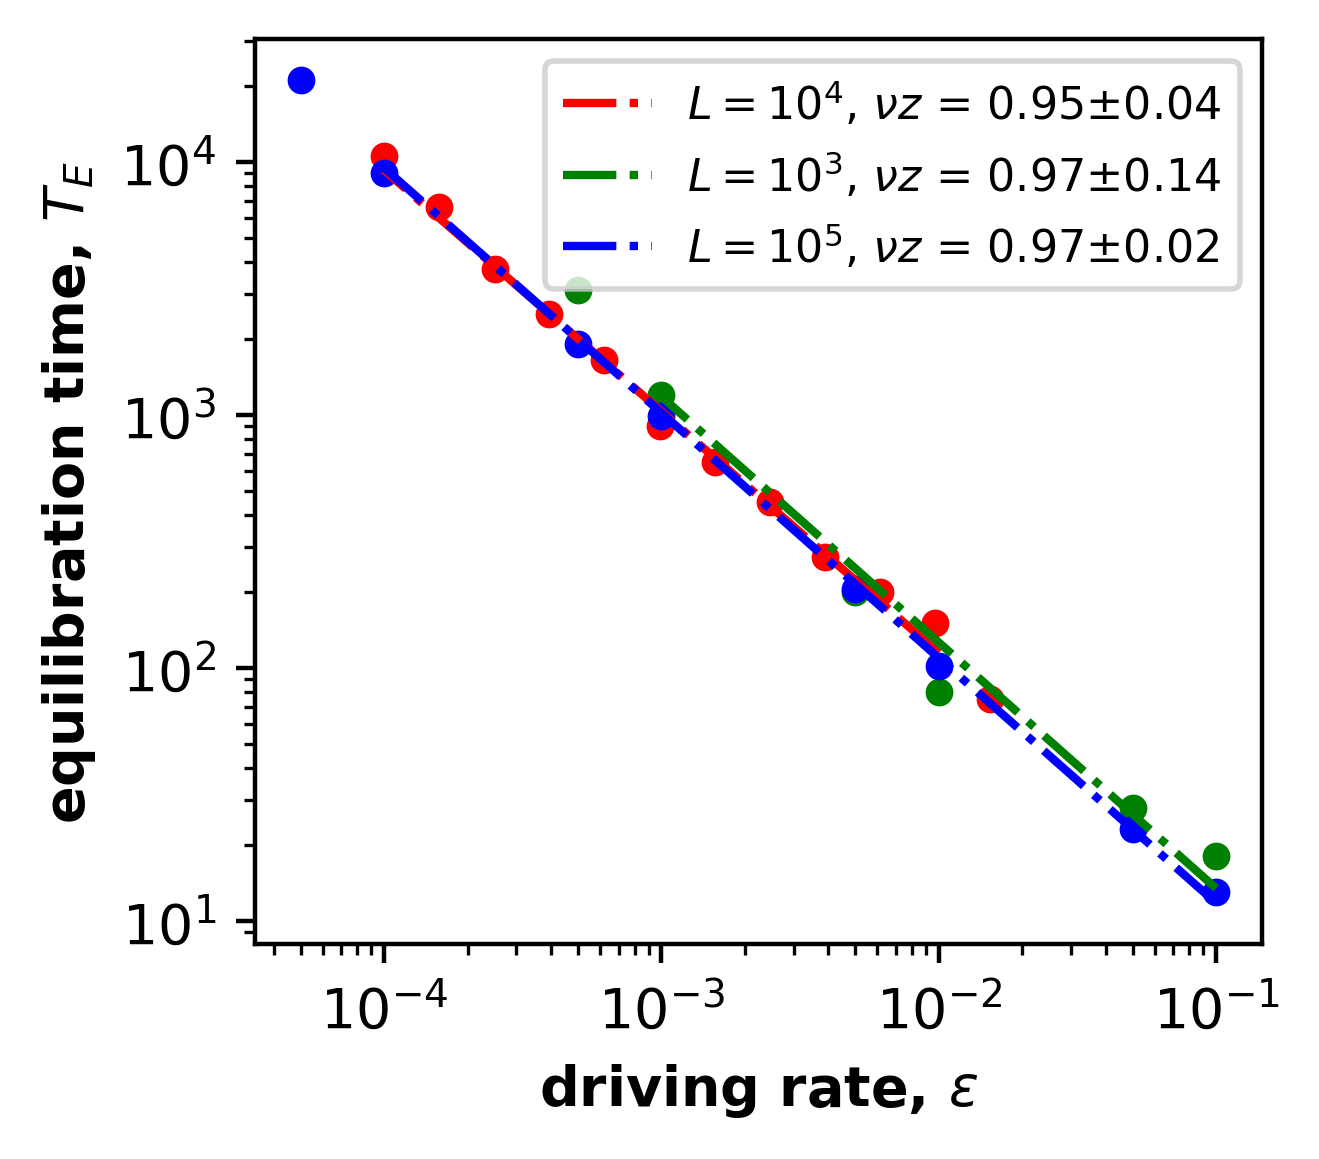

-0.9541609775085852
0.02251398792169115


In [9]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime4 = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU4 = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps4 = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]

approx_Relaxtime3 = [3100, 1200,200,80,28,18]
approx_RelaxtimeU3 = [9800,2000,600,150,90,11]
relaxtime_eps3 = [5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

approx_Relaxtime5 = [21000, 9000, 1900, 990, 205, 102, 23, 13]
approx_RelaxtimeU5 = [50000, 11000, 2000, 1200, 220, 130, 40, 20]
relaxtime_eps5 = [5.0E-5, 1.0E-4, 5.0E-04, 1.0E-03, 5.0E-03, 1.0E-02, 5.0E-02, 1.0E-01]


# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps4,approx_Relaxtime4,color='red',linewidth=0,markersize = mks, marker='o',)
ax1.plot(relaxtime_eps3,approx_Relaxtime3,color='green',linewidth=0,markersize = mks, marker='o',)
ax1.plot(relaxtime_eps5,approx_Relaxtime5,color='blue',linewidth=0,markersize = mks, marker='o',)
# ax2.plot(relaxtime_eps,approx_RelaxtimeU,color='red',linewidth=0,marker='.')

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps4[2:end]),np.log10(approx_Relaxtime4[2:end]))
popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps3[:]),np.log10(approx_Relaxtime3[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_Relaxtime5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev2 = np.sqrt(np.diag(pcov2)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(-2,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.',
         label=r'$L=10^4$, $\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev1,2)))
xEps = np.linspace(-1,-3,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
         color='green',linestyle='-.',
         label=r'$L=10^3$, $\nu z$ = '+ str(-1 * round(popt2[0],2)) + '$\pm$' + str(round(1.96*stdDev2,2)))
xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
         color='blue',linestyle='-.',
         label=r'$L=10^5$, $\nu z$ = '+ str(-1 * round(popt3[0],2)) + '$\pm$' + str(round(1.96*stdDev3,2)))


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )

ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_epsi.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print(popt1[0])
print(np.sqrt(np.diag(pcov1)[0]))

Now doing the same as above, but $T_E$ is measured using the number of unique clusters, $U$. 

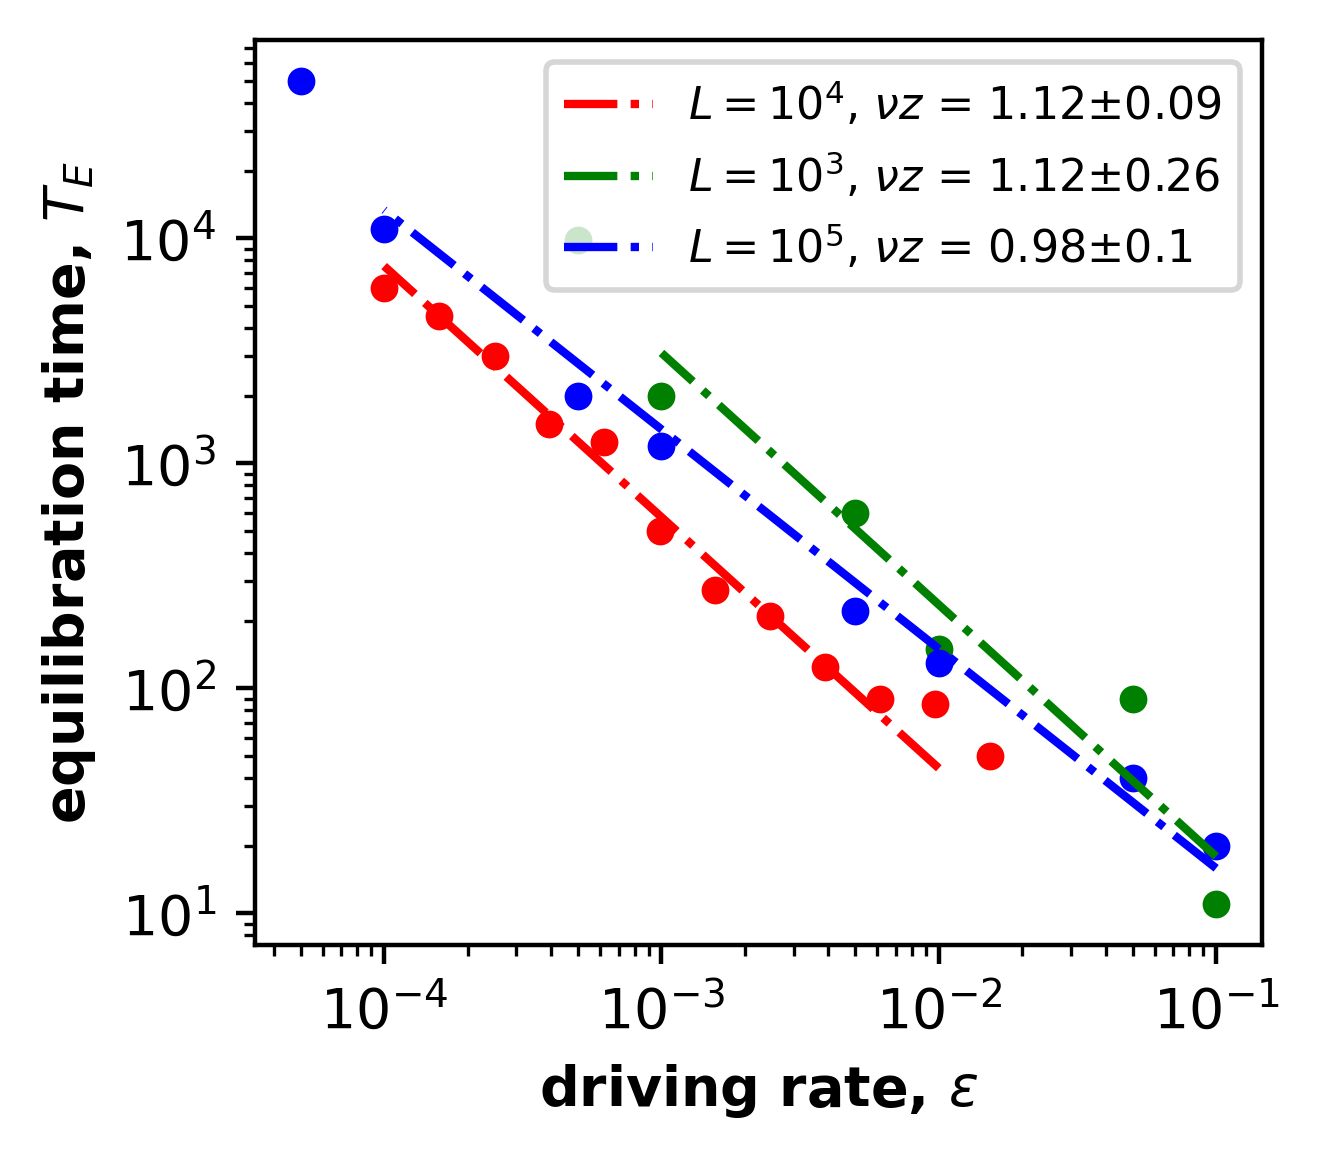

-1.1160503250665095
0.04679177130613802


In [11]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime4 = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU4 = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps4 = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]

approx_Relaxtime3 = [3100, 1200,200,80,28,18]
approx_RelaxtimeU3 = [9800,2000,600,150,90,11]
relaxtime_eps3 = [5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

approx_Relaxtime5 = [21000, 9000, 1900, 990, 205, 102, 23, 13]
approx_RelaxtimeU5 = [50000, 11000, 2000, 1200, 220, 130, 40, 20]
relaxtime_eps5 = [5.0E-5, 1.0E-4, 5.0E-04, 1.0E-03, 5.0E-03, 1.0E-02, 5.0E-02, 1.0E-01]


# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps4,approx_RelaxtimeU4,color='red',linewidth=0,markersize = mks, marker='o',)
ax1.plot(relaxtime_eps3,approx_RelaxtimeU3,color='green',linewidth=0,markersize = mks, marker='o',)
ax1.plot(relaxtime_eps5,approx_RelaxtimeU5,color='blue',linewidth=0,markersize = mks, marker='o',)
# ax2.plot(relaxtime_eps,approx_RelaxtimeU,color='red',linewidth=0,marker='.')

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps4[2:end]),np.log10(approx_RelaxtimeU4[2:end]))
popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps3[:]),np.log10(approx_RelaxtimeU3[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_RelaxtimeU5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev2 = np.sqrt(np.diag(pcov2)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(-2,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.',
         label=r'$L=10^4$, $\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev1,2)))
xEps = np.linspace(-1,-3,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
         color='green',linestyle='-.',
         label=r'$L=10^3$, $\nu z$ = '+ str(-1 * round(popt2[0],2)) + '$\pm$' + str(round(1.96*stdDev2,2)))
xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
         color='blue',linestyle='-.',
         label=r'$L=10^5$, $\nu z$ = '+ str(-1 * round(popt3[0],2)) + '$\pm$' + str(round(1.96*stdDev3,2)))


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )

ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_epsi.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print(popt1[0])
print(np.sqrt(np.diag(pcov1)[0]))

Directly comparing the plots for $\rho$ and for $U$

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


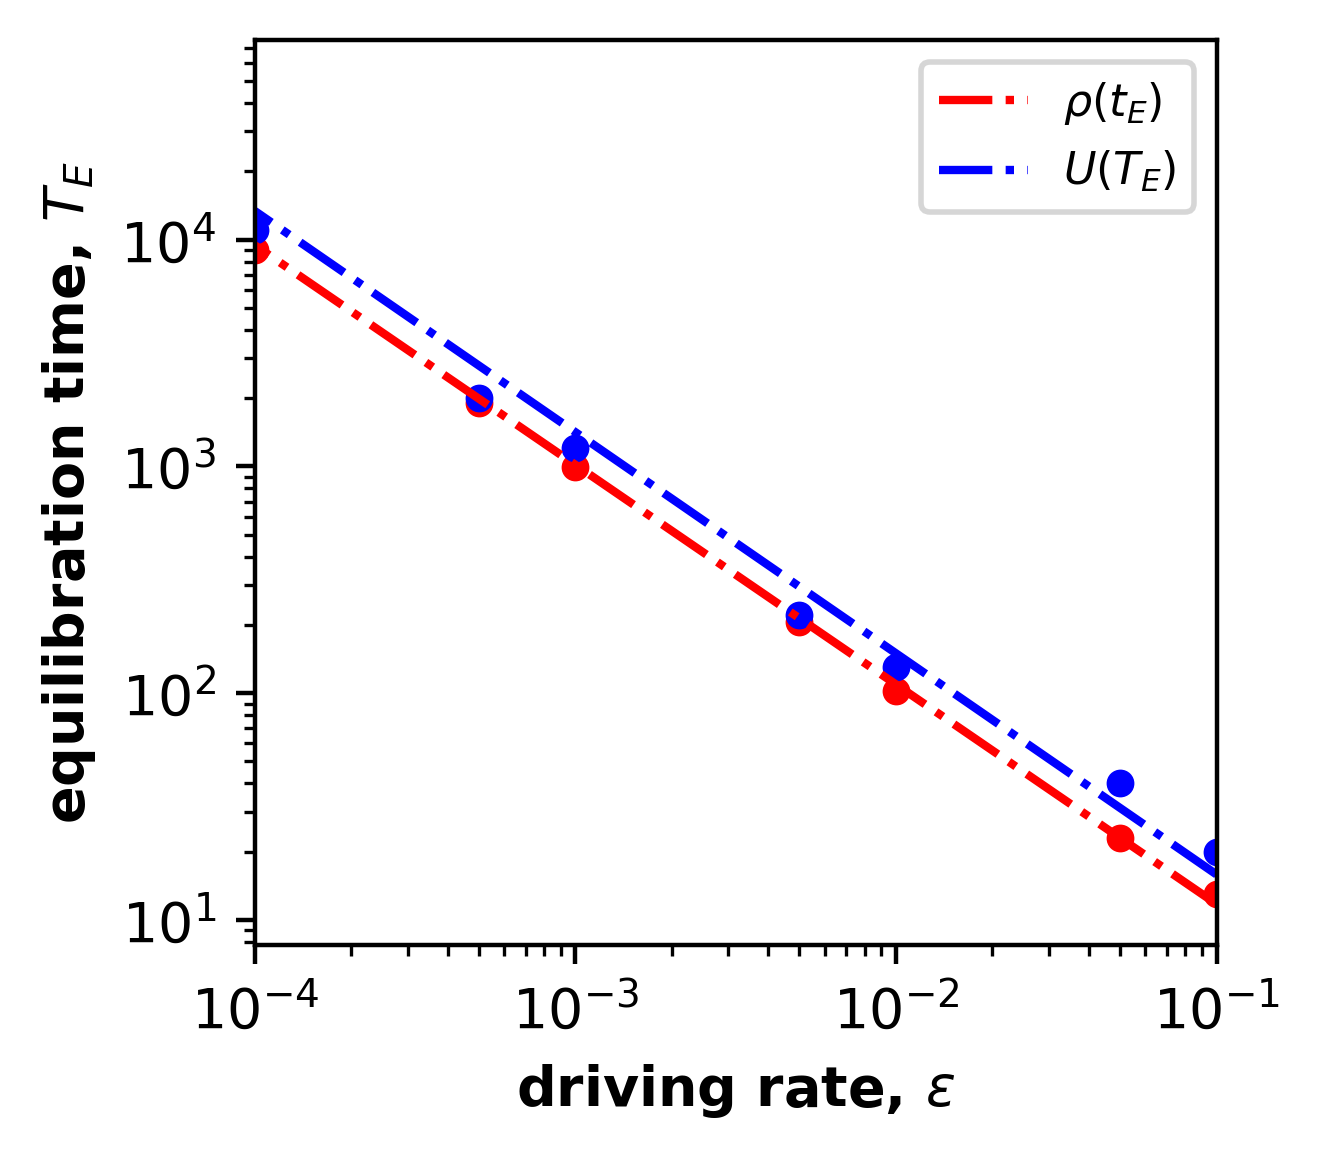

-0.9683623175880784
0.010838448594337564


In [3]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime4 = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU4 = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps4 = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]

approx_Relaxtime3 = [3100, 1200,200,80,28,18]
approx_RelaxtimeU3 = [9800,2000,600,150,90,11]
relaxtime_eps3 = [5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

approx_Relaxtime5 = [21000, 9000, 1900, 990, 205, 102, 23, 13]
approx_RelaxtimeU5 = [50000, 11000, 2000, 1200, 220, 130, 40, 20]
relaxtime_eps5 = [5.0E-5, 1.0E-4, 5.0E-04, 1.0E-03, 5.0E-03, 1.0E-02, 5.0E-02, 1.0E-01]


# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps5,approx_Relaxtime5,color='red',linewidth=0,markersize = mks, marker='o',)
# ax1.plot(relaxtime_eps3,approx_RelaxtimeU3,color='green',linewidth=0,markersize = mks, marker='o',)
ax1.plot(relaxtime_eps5,approx_RelaxtimeU5,color='blue',linewidth=0,markersize = mks, marker='o',)

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_Relaxtime5[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_RelaxtimeU5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.',
         label=r'$\rho(t_E)$')
xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
         color='blue',linestyle='-.',
         label=r'$U(T_E)$')


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )
ax1.set_xlim(left=1e-4, right=1e-1)
ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_epsi.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print(popt1[0])
print(np.sqrt(np.diag(pcov1)[0]))

In [5]:
for i in np.logspace(-4,-1,13): 
    print(i)

0.0001
0.00017782794100389227
0.00031622776601683794
0.0005623413251903491
0.001
0.0017782794100389228
0.0031622776601683794
0.005623413251903491
0.01
0.01778279410038923
0.03162277660168379
0.05623413251903491
0.1


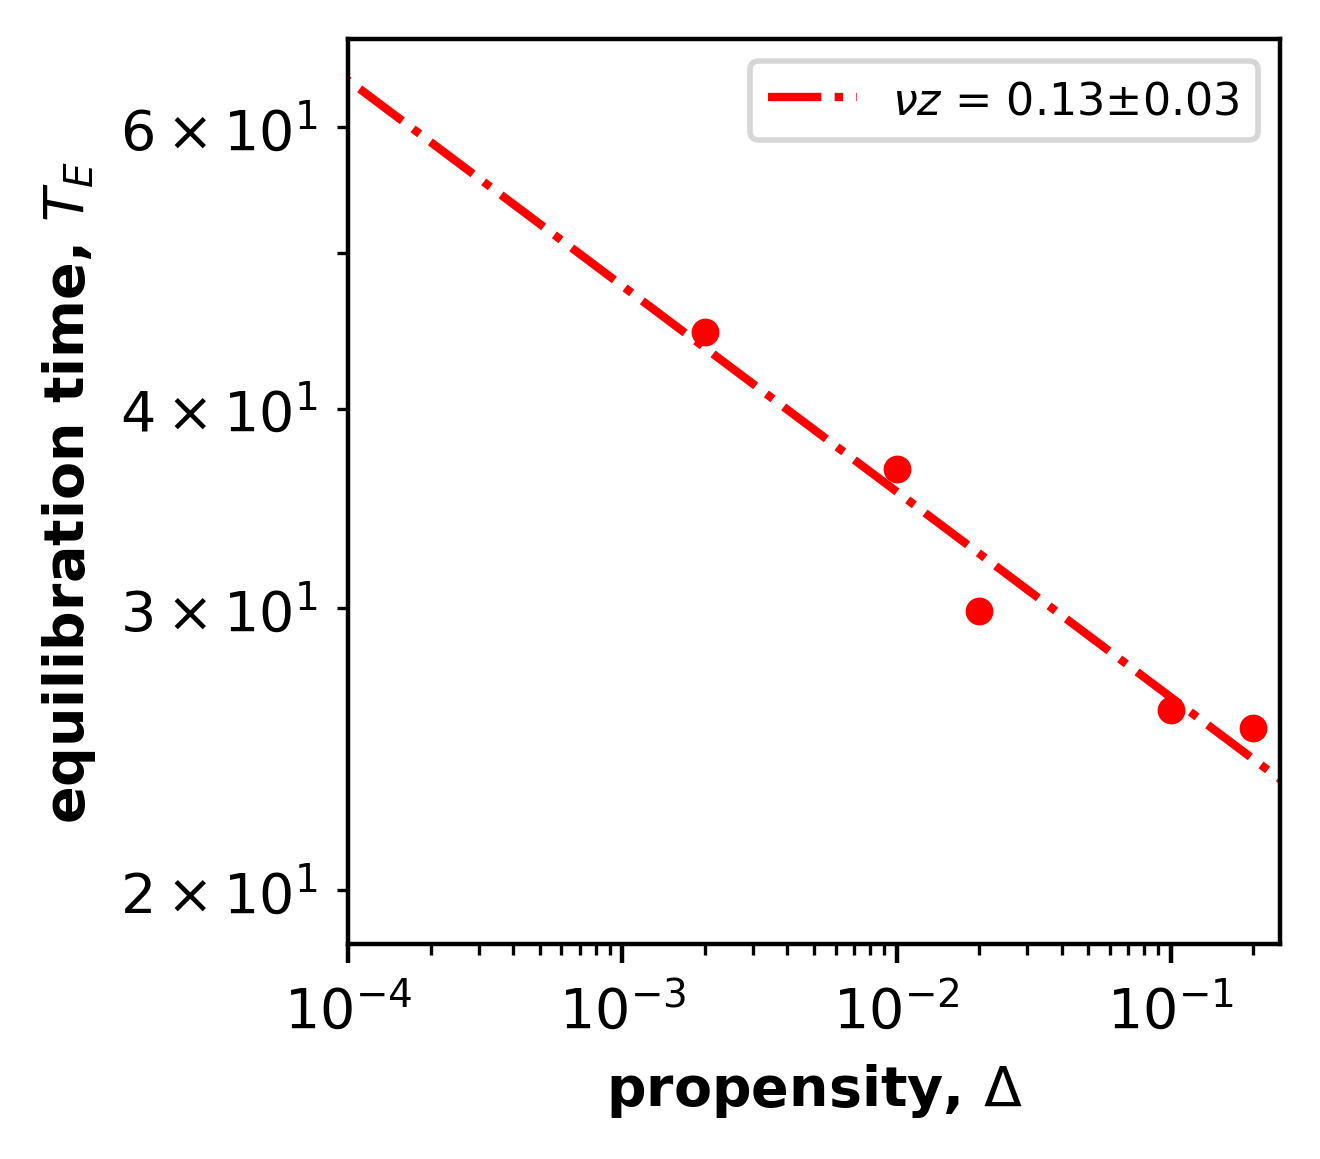

-0.12854681414770744
0.016322538280385136


In [12]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime5 = [25.272, 25.926, 29.894, 36.664, 44.667]
approx_RelaxtimeU5 = [30, 32, 32, 33, 34]
relaxtime_eps5 = [0.2, 0.1, 0.02, 0.01, 0.002]


# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps5,approx_Relaxtime5,color='red',linewidth=0,markersize = mks, marker='o',)
# ax1.plot(relaxtime_eps5,approx_RelaxtimeU5,color='blue',linewidth=0,markersize = mks, marker='o',)

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_Relaxtime5[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_RelaxtimeU5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(-0,-4,100)
# ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#          color='red',linestyle='-.',
#          label=r'$\rho(t_E)$')
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.',
         label=r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev1,2)))
xEps = np.linspace(-0,-4,100)
# ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
#          color='blue',linestyle='-.',
#          label=r'$U(T_E)$')


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'propensity, $\Delta$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )
ax1.set_xlim(left=1e-4, right=2.5e-1)
ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_prop.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print(popt1[0])
print(np.sqrt(np.diag(pcov1)[0]))

## Final Plots CP (most data points and both quantities) 

Note, these values are for the contact process dynamics, not for the random walker, and therefore, are not actual the final plots. 

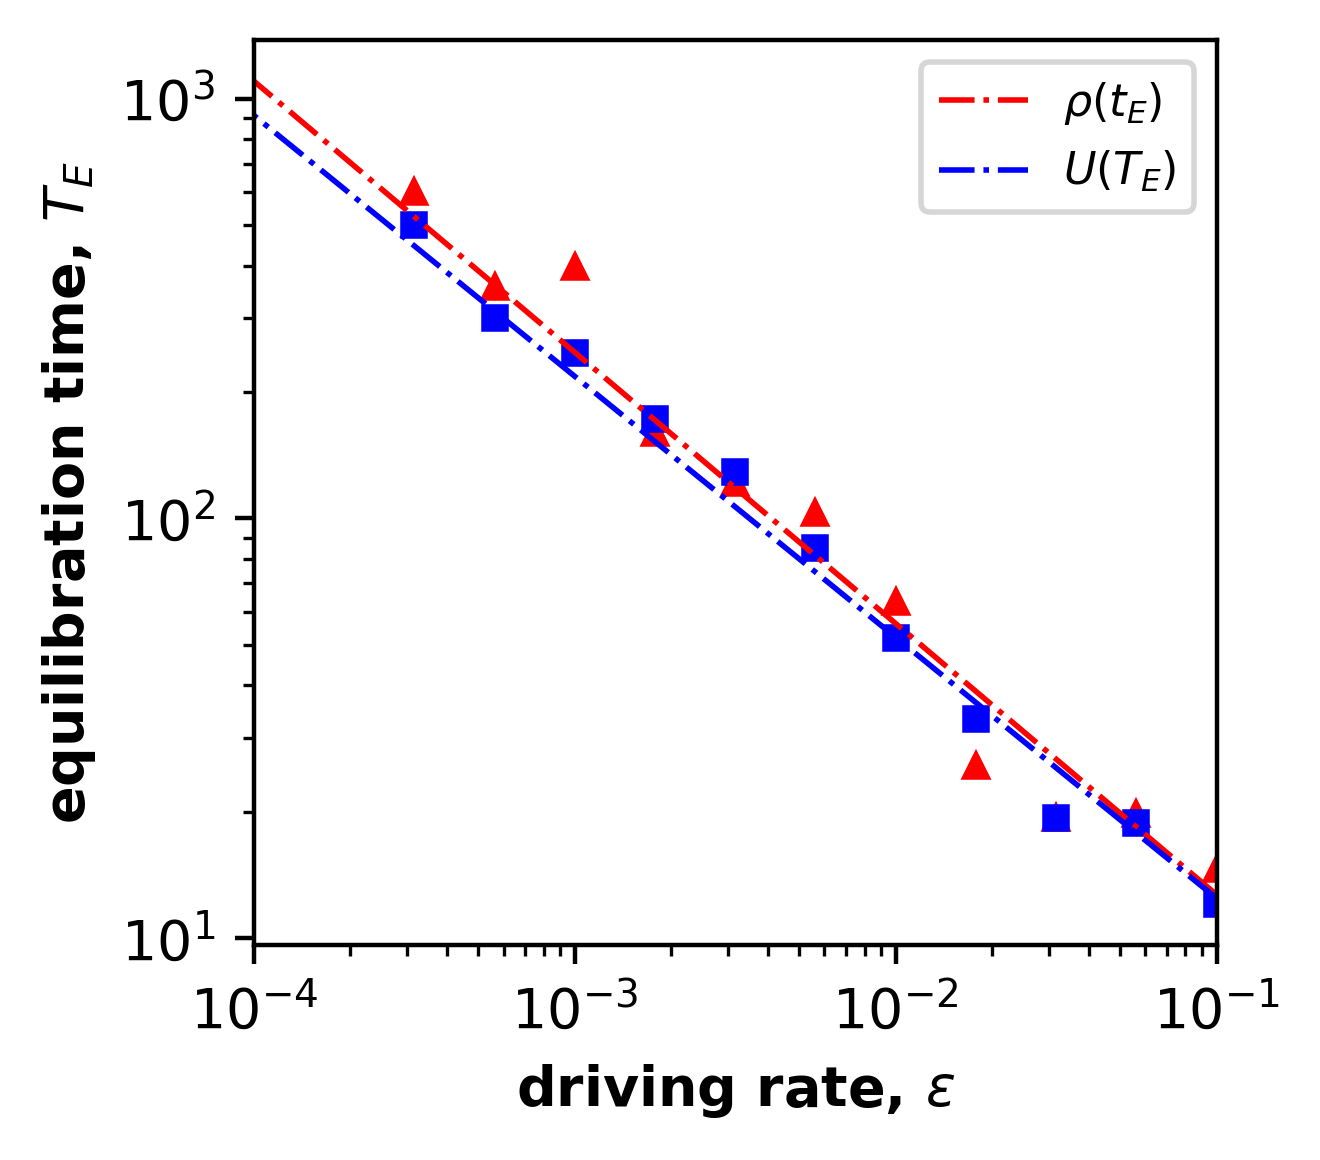

from rho: nu= -0.6459784511775979 pm 0.038163757042276876
from U: nu= -0.6216245057541275 pm 0.02361722345091045


In [19]:
np.logspace(-4,-1,13)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime5 = [14.631, 19.723, 19.313, 25.735, 63.231, 102.790, 121.336, 159.348015873, 396.865, 356.559, 600, 758]
approx_RelaxtimeU5 = [12.0617, 18.820, 19.369, 33.288, 52.017, 85.211, 128.64, 172.4904761905, 248.04398, 300.6791176471, 501, 666]
relaxtime_eps5 = [0.1, 0.05623, 0.03162, 0.01778, 0.01, 0.005623, 0.003162, 0.001778, 0.001, 0.0005623, 0.0003162, 0.0001]


# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps5[:-1],approx_Relaxtime5[:-1],color='red',linewidth=0,markersize = mks, marker='^',)
ax1.plot(relaxtime_eps5[:-1],approx_RelaxtimeU5[:-1],color='blue',linewidth=0,markersize = mks, marker='s',)

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_Relaxtime5[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_RelaxtimeU5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.', linewidth=1, 
         label=r'$\rho(t_E)$')
xEps = np.linspace(-1,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
         color='blue',linestyle='-.', linewidth=1, 
         label=r'$U(T_E)$')


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )
ax1.set_xlim(left=1e-4, right=1e-1)
ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_epsi.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print("from rho: nu=", popt1[0], "pm", np.sqrt(np.diag(pcov1)[0]))

print("from U: nu=", popt3[0], "pm", np.sqrt(np.diag(pcov3)[0]))


## Final Plots RW

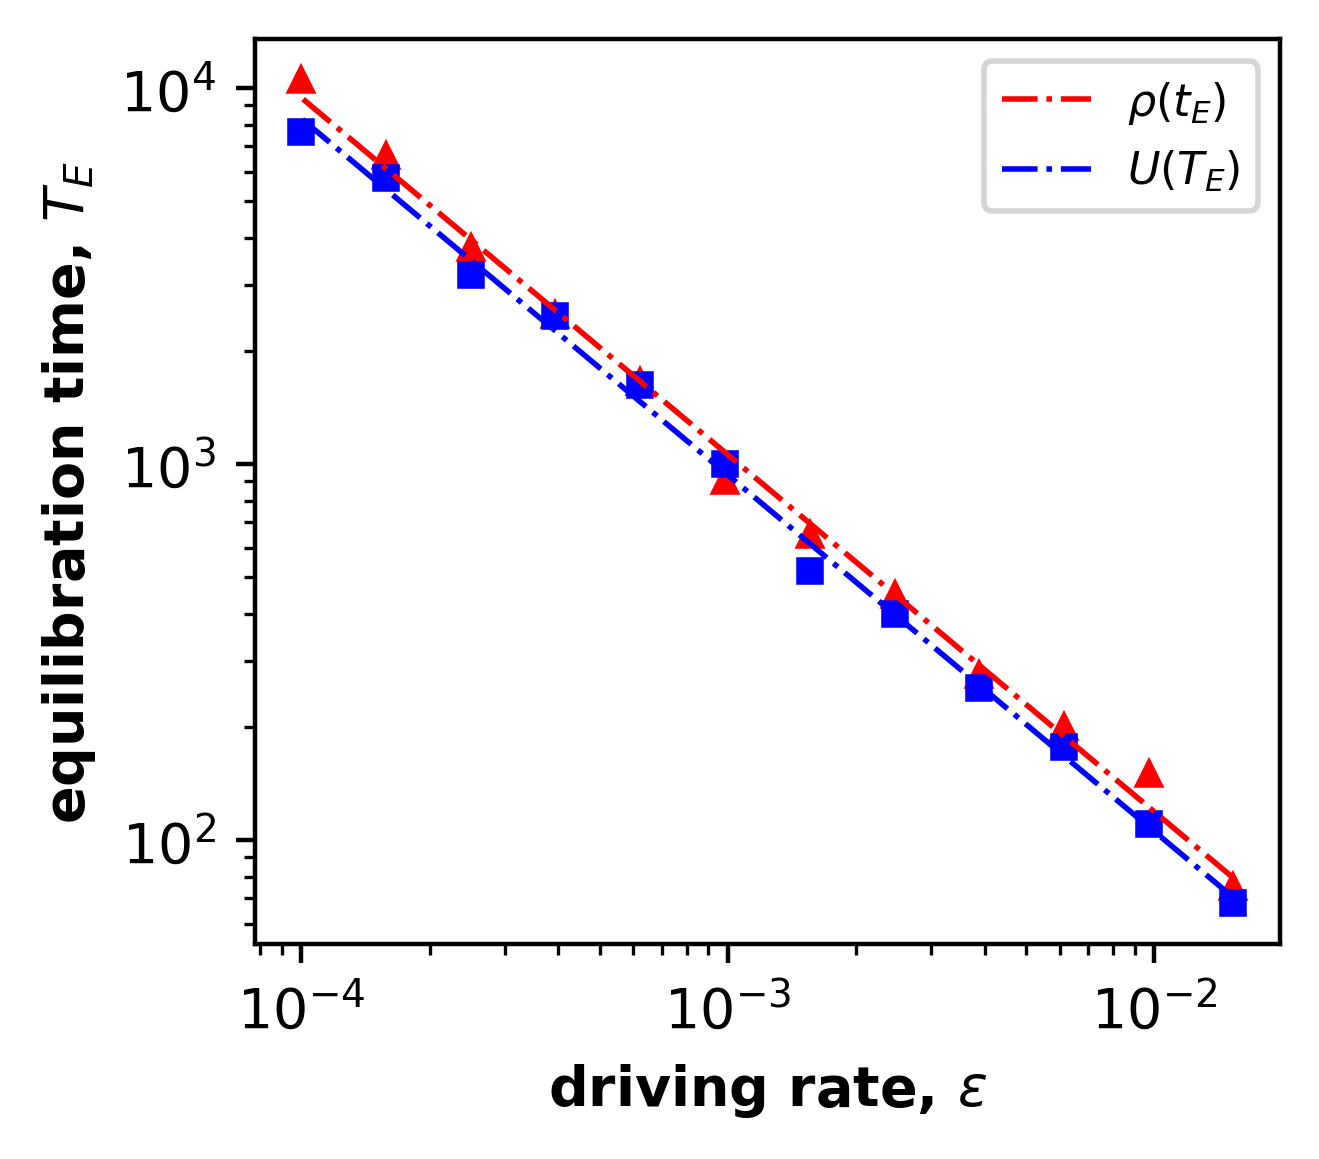

from rho: nu= -0.949353375529569 pm 0.018994146679147915
from U: nu= -0.9477619494238733 pm 0.015856234971102667


In [4]:
np.logspace(-4,-1,13)

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_RelaxtimeU5 = [68.0851, 110.381, 177.465, 253.333, 400, 520, 1000, 1620, 2483, 3179.487, 5773.585, 7628.866]
approx_Relaxtime5 = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
relaxtime_eps5 = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]



# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) ,dpi=200, frameon=True)   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size

ax1.plot(relaxtime_eps5,approx_Relaxtime5,color='red',linewidth=0,markersize = mks, marker='^',)
ax1.plot(relaxtime_eps5,approx_RelaxtimeU5,color='blue',linewidth=0,markersize = mks, marker='s',)

# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_Relaxtime5[:]))
popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps5[:]),np.log10(approx_RelaxtimeU5[:]))
stdDev1 = np.sqrt(np.diag(pcov1)[0])
stdDev3 = np.sqrt(np.diag(pcov3)[0])

xEps = np.linspace(np.log10(relaxtime_eps5[0]),np.log10(relaxtime_eps5[-1]),100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='red',linestyle='-.', linewidth=1, 
         label=r'$\rho(t_E)$')
# xEps = np.linspace(-2,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
         color='blue',linestyle='-.', linewidth=1, 
         label=r'$U(T_E)$')


# print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )
# ax1.set_xlim(left=1e-4, right=1e-1)
ax1.legend(loc='upper right', fontsize=8);
# ax1.grid(True)
plt.savefig('relaxTime_epsi.pdf', format='pdf', dpi=360, bbox_inches = "tight")
plt.show(fig)

print("from rho: nu=", popt1[0], "pm", np.sqrt(np.diag(pcov1)[0]))

print("from U: nu=", popt3[0], "pm", np.sqrt(np.diag(pcov3)[0]))



# Measuring $\alpha$ exponenet from DP

if we start with a fully occupied lattice at the critical bond probability, $p=p_c$, the density of active sites (particles) decays like
\begin{equation}
\rho(t) \sim t^{-\alpha}
\end{equation}
where $\alpha = \beta / \nu^\parallel$. 

In [21]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [12]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts


def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(16,3,wspace=0.25,hspace=0.2)
    ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [ ]:
startIndex = [3]#,8,13,18,23,28]
# for start in startIndex:
start = 3
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(start) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(start) + "_timeAct.png"
activity, parts = activityAdding(timeString, 4, 9, 100, True, savename)
activityDensityPlots(timeString, 4, 9, 100, True, savename)

for i in range(start+1 ,start+5):
    print(i)
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activity += activityAdding(timeString, 4, 9, 100, True, savename)[0]
    activityDensityPlots(timeString, 4, 9, 100, True, savename)

# savename = 'Plots/brain2xx/brainAvg_2' + "{:0>2d}".format(start) + '_2' + "{:0>2d}".format(i) + '.png'
plotActivity(activity/5, 15, 3, 1, False, savename,parts)

In [23]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    rawparts = [lines[0],lines[1],lines[2]]
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts, rawparts

# ============================================================================================================
# ============================================================================================================
# ============================================================================================================

def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(9,3,wspace=0.3,hspace=0.4)
    ax2 = fig.add_subplot(grid[:7,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:7,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:7,2]) # avg Cluster Size vs. Time
    
    ax21 = fig.add_subplot(grid[-1,0]) # Active Sites vs. Time
    ax31 = fig.add_subplot(grid[-1,1]) # Unique Clusters vs. Time
    ax41 = fig.add_subplot(grid[-1,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    
    ax21.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax21.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    ax41.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax41.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    
    ax31.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax31.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

# ============================================================================================================
# ============================================================================================================
# ============================================================================================================

startIndex = np.arange(300,400,10)
for start in startIndex:
    timeString = 'brain_102xx/brain10' + "{:0>2d}".format(start) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain102xx/brain2' + "{:0>2d}".format(start) + "_timeAct.png"
    activity, parts, rawparts = activityAdding(timeString, 4, 9, 100, True, savename)
    plotActivity(activity, 12, 4, 100, True, savename, parts)

    for i in range(start+1 ,start+10):
        timeString = 'brain_102xx/brain10' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
        savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
        activityStep = activityAdding(timeString, 4, 9, 100, True, savename)[0]
        activity += activityStep
        plotActivity(activityStep, 12, 4, 100, True, savename, parts)

#     activity /= 10

#     filename = 'brainAvg_10' + "{:0>1d}".format(start) + 'x.txt'
#     f= open(filename,"w+")
#     for string in rawparts:
#         f.writelines([string, '\n'])

#     for t in range(len(activity[:,0])):
#         f.writelines([str(int(activity[t,0])), '      ', str(activity[t,1]), '       ', str(activity[t,2]), '\n'])

#     f.close()

brain_102xx/brain10300_timeData.txt


KeyboardInterrupt: 

In [126]:
np.arange(200,410,10)

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400])

In [ ]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[111,49,55],
[152,52,45],
[223,66,59],
[211,134,120],
[210,114,50],
[126,90,44],
[207,157,60],
[170,166,103],
[164,183,56],
[84,140,50],
[86,116,66],
[45,72,33],
[86,196,68],
[91,186,128],
[81,169,165],
[100,143,191],
[115,111,210],
[109,57,193],
[92,57,112],
[205,77,197],
[198,137,184],
[199,67,125]])/255
cp = -1

plotSeeds= np.arange(1,23)
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain1xx/epsi_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

starting i=90


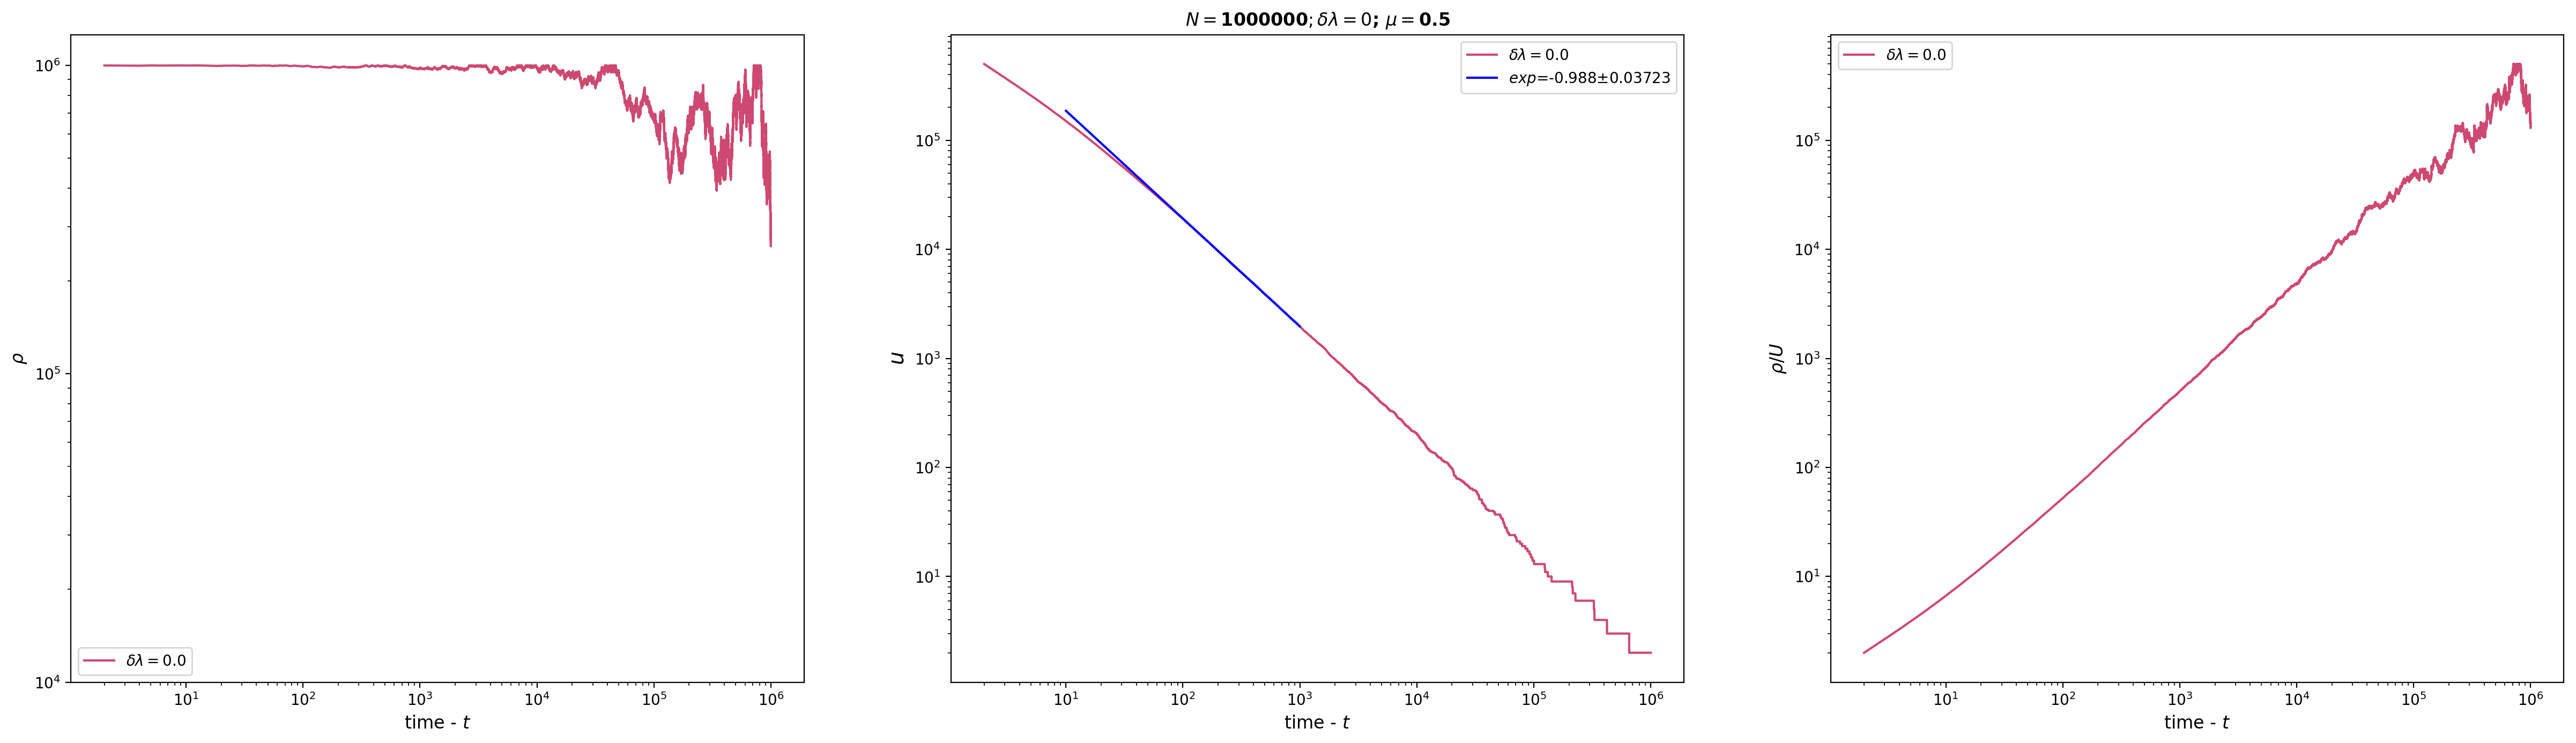

In [41]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[206,73,114],
[130,65,49],
[214,79,51],
[203,143,80],
[164,170,66],
[76,100,49],
[89,185,73],
[97,175,146],
[99,140,194],
[104,74,195],
[98,54,105],
[201,77,196],
[199,136,181]])/255
cp = -1

# plotSeeds= [89,88,87,86,85,84,90,96,95,94,93,92,91]
plotSeeds = [90]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
    endFit = 1000
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[100:endFit,0]),np.log10(activityDensity[100:endFit,2]))
    xEps = np.linspace(1,np.log10(endFit),100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)) + '$\pm$' + str(round(1.96*stdDev,5)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/deltaLambd_timeStats.png'
# fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

In [ ]:
color_list = np.array([[245,149,146],
[255,213,197],
[255,204,155],
[190,171,147],
[189,169,132],
[217,203,128],
[243,255,177],
[240,255,198],
[144,223,170],
[120,219,179],
[207,255,238],
[169,255,236],
[122,183,171],
[74,206,188],
[173,216,210],
[72,188,186],
[31,201,206],
[141,245,255],
[137,178,193],
[57,200,245],
[158,226,255],
[255,194,240]])/255
print(color_list)

In [13]:
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

y = gen_log_space(2000,50)
print(y)

[   0    1    2    3    4    5    6    7    8    9   11   13   14   17
   19   22   25   29   33   38   43   49   56   65   74   84   96  110
  125  143  164  187  213  243  277  316  361  412  470  536  612  698
  796  908 1035 1181 1347 1537 1753 1999]


starting i=10


ValueError: too many values to unpack (expected 2)

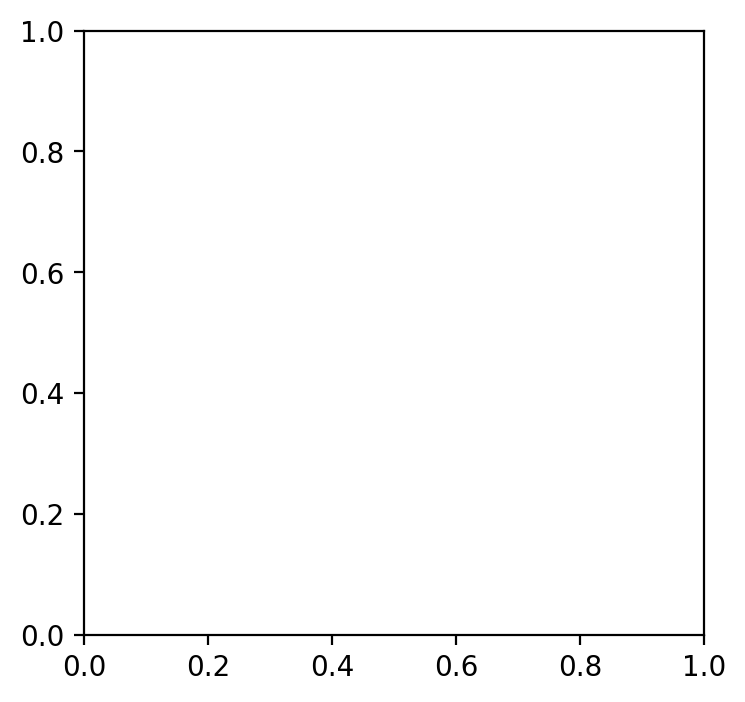

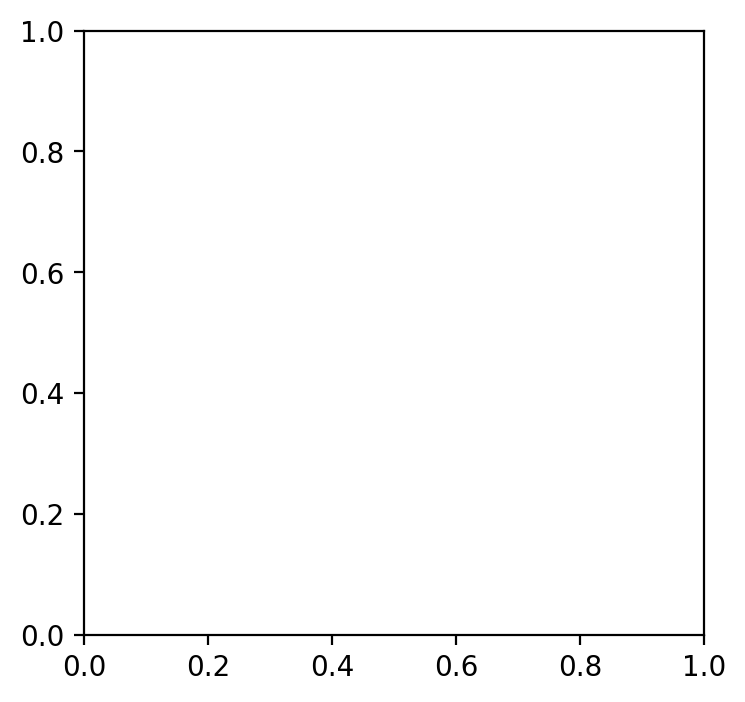

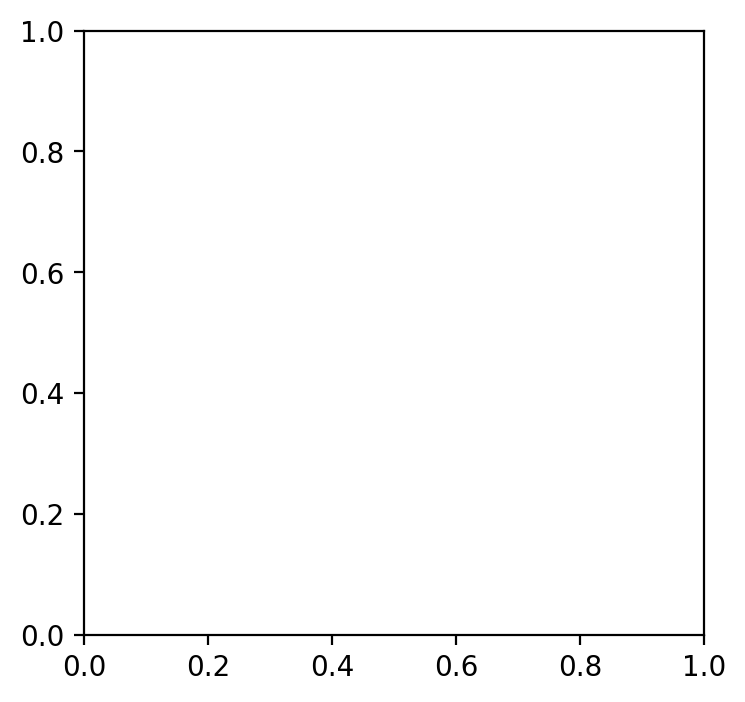

In [24]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig2 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax2 = fig2.add_subplot(grid[0,0]) # Active Sites vs. Time
fig3 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax3 = fig3.add_subplot(grid[0,0]) # Unique Clusters vs. Time
fig4 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax4 = fig4.add_subplot(grid[0,0]) # avg Cluster Size vs. Time

color_list = ['blue','red','black','green']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [10,18,1]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
#     print(activityDensity)
    
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain1xx/epsi_timeStats.png'
# fig2.savefig('Plots/5_alpha_rho_epsi.png', dpi=360,bbox_inches = "tight")
# fig3.savefig('Plots/5_alpha_U_epsi.png', dpi=360,bbox_inches = "tight")
# fig4.savefig('Plots/5_alpha_rhoU_epsi.png', dpi=360,bbox_inches = "tight")
plt.show(fig2); plt.show(fig3); plt.show(fig4)

In [ ]:
fig2 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax2 = fig2.add_subplot(grid[0,0]) # Active Sites vs. Time
fig3 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax3 = fig3.add_subplot(grid[0,0]) # Unique Clusters vs. Time
fig4 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax4 = fig4.add_subplot(grid[0,0]) # avg Cluster Size vs. Time

color_list = ['blue','red','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [86, 88, 90]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
#     activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain2xx/deltaLambd_timeStats.png'
fig2.savefig('Plots/5_alpha_rho_deltLamb.png', dpi=360,bbox_inches = "tight")
fig3.savefig('Plots/5_alpha_U_deltLamb.png', dpi=360,bbox_inches = "tight")
fig4.savefig('Plots/5_alpha_rhoU_deltLamb.png', dpi=360,bbox_inches = "tight")
plt.show(fig2); plt.show(fig3); plt.show(fig4); 

## Time-averaged Data sets (over 10 runs, seed 102xx)

In [25]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\Delta=$'+str(parts[2])+'; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)
        

def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts

starting: brain_102xx/brainAvg_10400x.txt
starting: brain_102xx/brainAvg_10300x.txt
starting: brain_102xx/brainAvg_10310x.txt
starting: brain_102xx/brainAvg_10320x.txt
starting: brain_102xx/brainAvg_10330x.txt
starting: brain_102xx/brainAvg_10340x.txt
starting: brain_102xx/brainAvg_10350x.txt
starting: brain_102xx/brainAvg_10360x.txt
starting: brain_102xx/brainAvg_10370x.txt
starting: brain_102xx/brainAvg_10380x.txt
starting: brain_102xx/brainAvg_10390x.txt


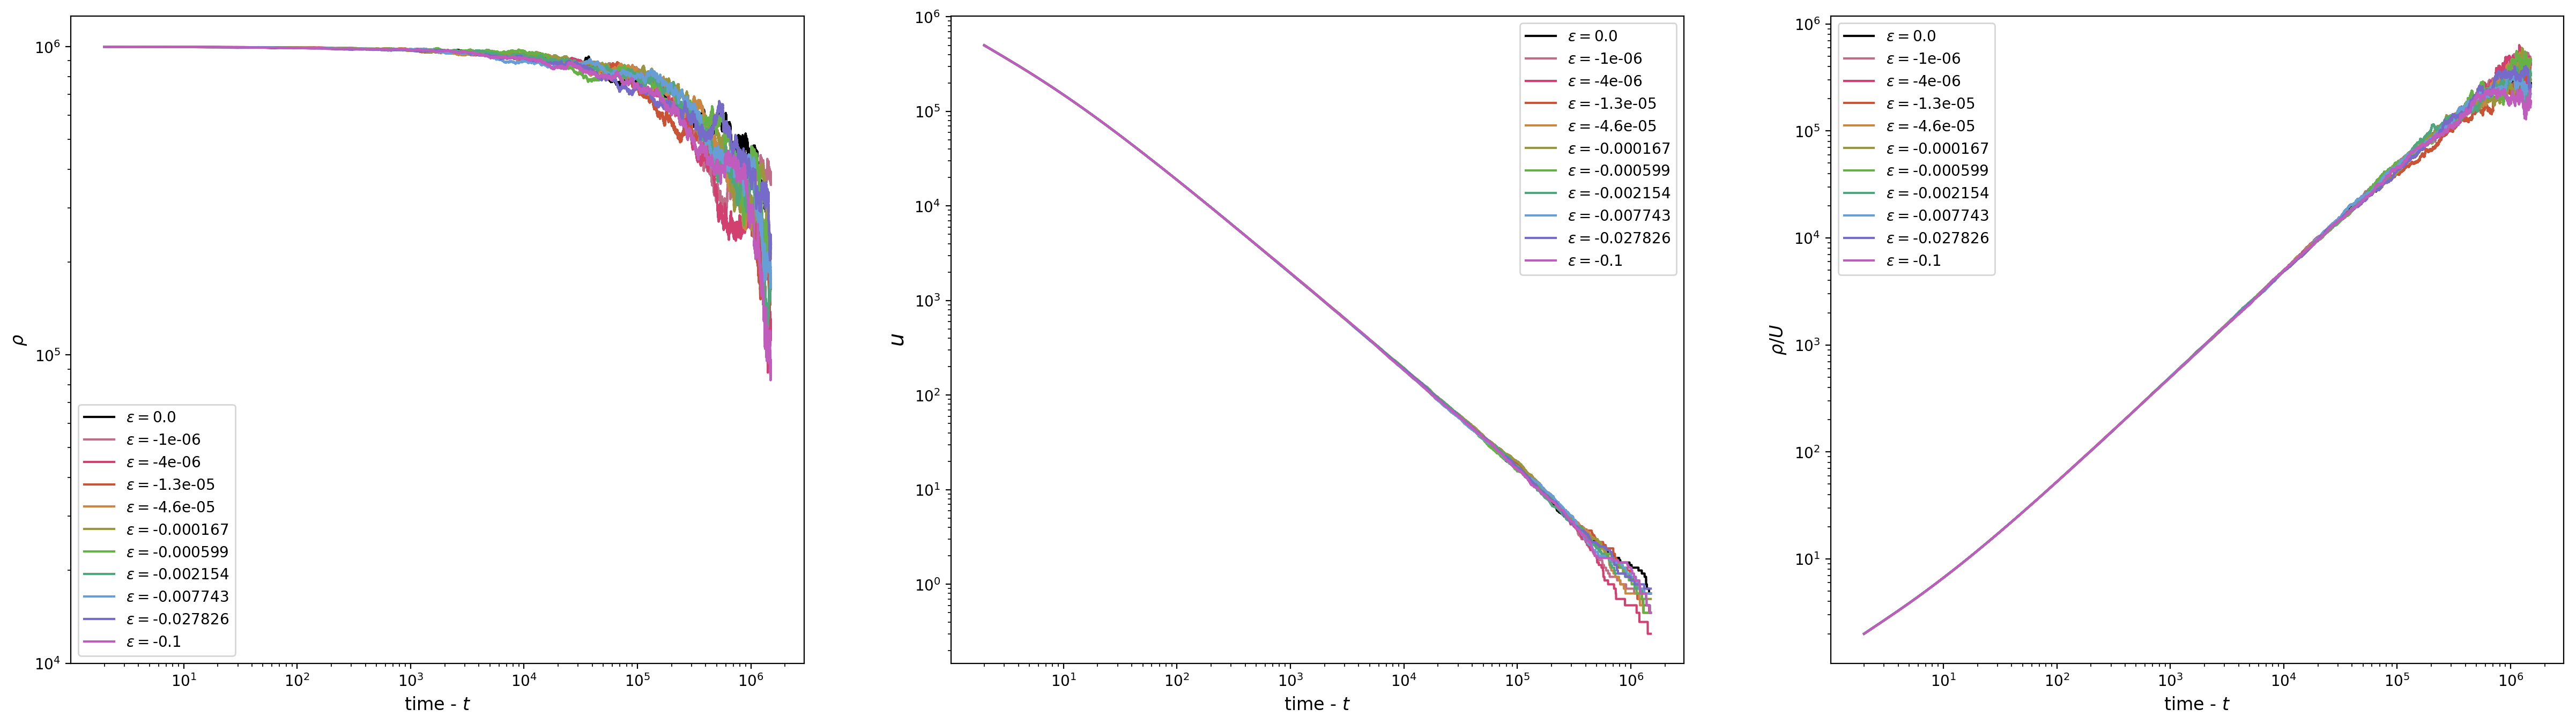

In [162]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[0,0,0],
[192,109,135],
[209,64,110],
[202,83,54],
[200,135,67],
[153,150,62],
[102,177,70],
[79,166,124],
[102,158,213],
[118,107,201],
[192,92,187]])/255
cp = -1

plotSeeds= [40,30,31,32,33,34,35,36,37,38,39]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x.txt"; print('starting: ' + timeString)
    savename = 'Plots/brain102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/epsi_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

starting: brain_102xx/brainAvg_10400x.txt
1499998
starting: brain_102xx/brainAvg_10200x.txt


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


1346132
starting: brain_102xx/brainAvg_10210x.txt
994103
starting: brain_102xx/brainAvg_10220x.txt
416983
starting: brain_102xx/brainAvg_10230x.txt
106606
starting: brain_102xx/brainAvg_10240x.txt
23439
starting: brain_102xx/brainAvg_10250x.txt
9374
starting: brain_102xx/brainAvg_10260x.txt
2790
starting: brain_102xx/brainAvg_10270x.txt
768
starting: brain_102xx/brainAvg_10280x.txt
243
starting: brain_102xx/brainAvg_10290x.txt
61


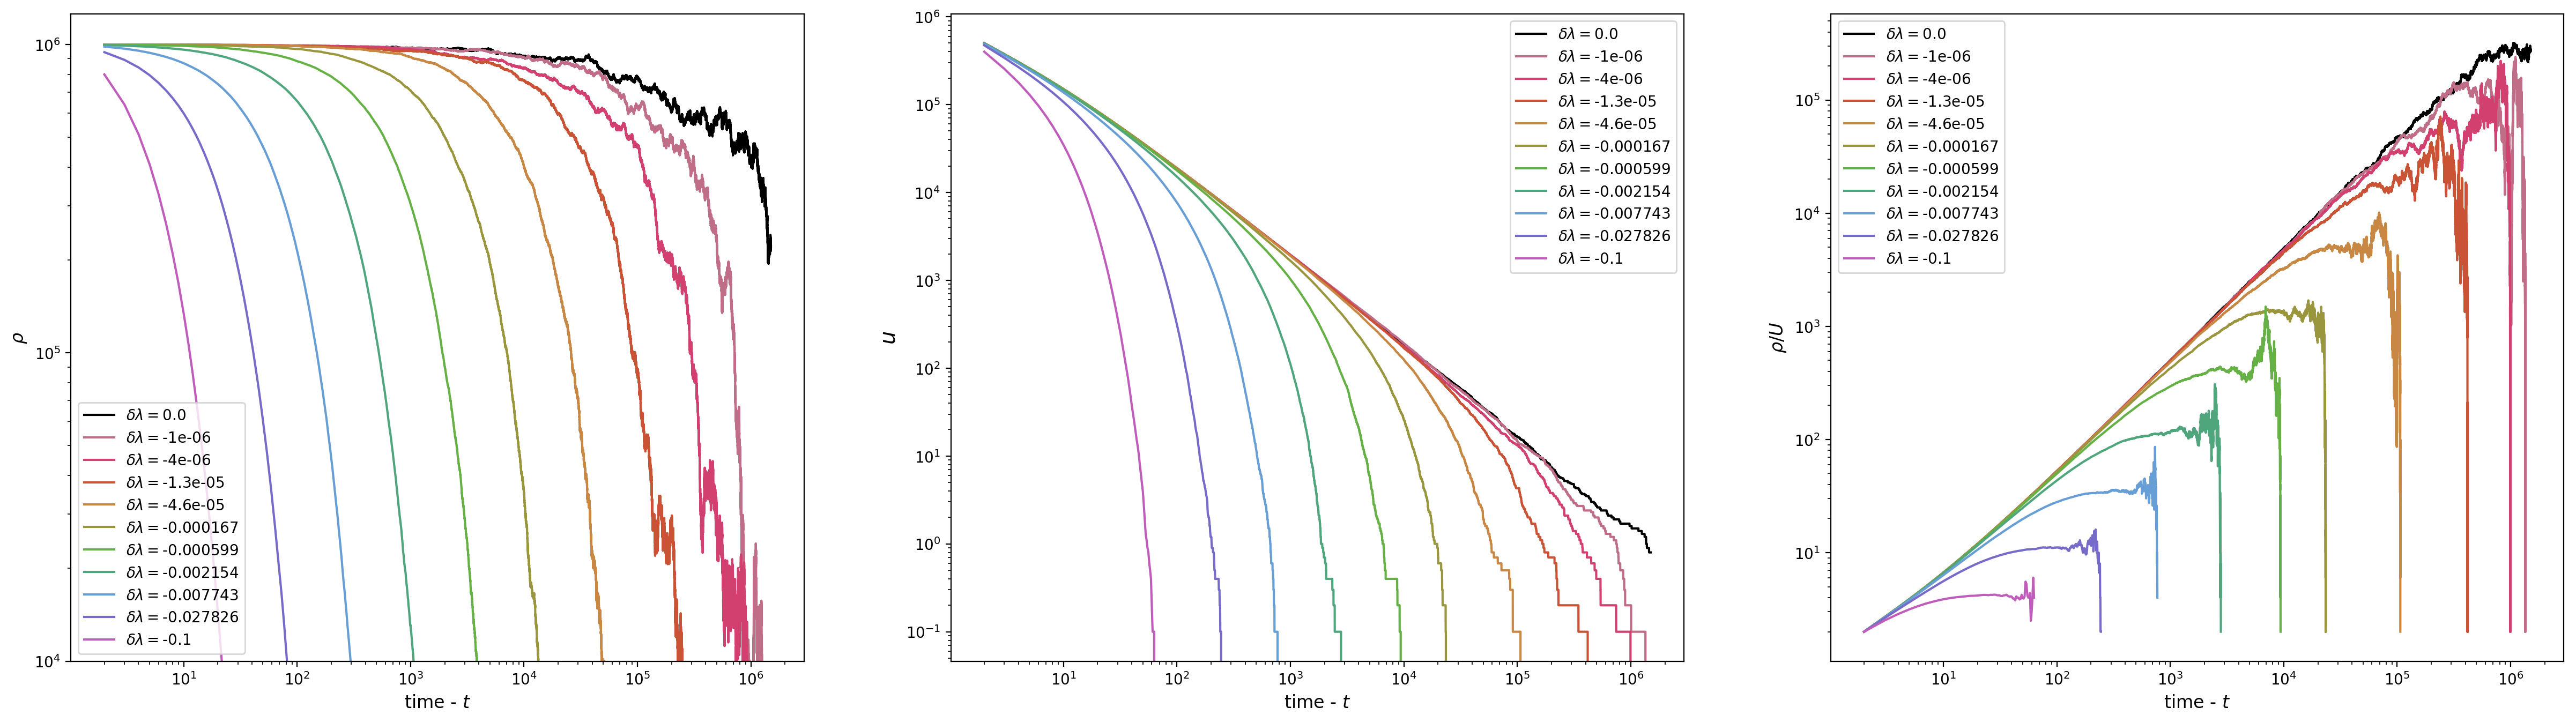

In [152]:
def func_logpowlaw(x,m,c):
    return m*x + c

def func_exp(x,zi,A):
    return A * np.exp(-x/zi)

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

corInv = []
color_list = np.array([[0,0,0],
[192,109,135],
[209,64,110],
[202,83,54],
[200,135,67],
[153,150,62],
[102,177,70],
[79,166,124],
[102,158,213],
[118,107,201],
[192,92,187]])/255
cp = -1

plotSeeds= [40,20,21,22,23,24,25,26,27,28,29]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x.txt"; print('starting: ' + timeString)
    savename = 'Plots/brain102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
    endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
    popt1,pcov1 = curve_fit(func_exp,activityDensity[0:endFit,0],activityDensity[0:endFit,1])
    xEps = np.logspace(0,np.log10(endFit),100)
#     ax2.plot(xEps,func_exp(xEps,*popt1),
#                 color=color_list[cp],label=r'$\xi$='+ str(round(popt1[0],3))+'; $\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)))
    corInv += [[float(parts[2]) - float(parts[3]), popt1[0]]]
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/deltaLambd_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

[[-2.280000000021154e-06, 203277.3996473993], [-5.179999999993523e-06, 65543.59805782724], [-1.1790000000011513e-05, 71240.84738691505], [-2.6829999999977705e-05, 16007.707019096044], [-6.105000000000693e-05, 7875.541812231514], [-0.00013895000000002655, 3401.951860827864], [-0.0003162299999999729, 1555.0171476377072], [-0.0007196899999999951, 714.6314180132359], [-0.0016378899999999752, 312.5186418718269], [-0.003727590000000003, 134.10693762683704], [-0.008483430000000014, 58.05972814039371], [-0.019306979999999974, 25.45911669316817], [-0.04393971000000002, 10.840529110083848], [-0.09999999999999998, -260782835.76938063], [0.0, 89.8738250426688], [-9.999999999732445e-07, 336682.3053370793], [-3.5899999999977616e-06, 133933.26184049578], [-1.2920000000027354e-05, 42591.8347164944], [-4.641999999999147e-05, 11123.565709894097], [-0.00016681000000001722, 3016.7149107470773], [-0.0005994799999999856, 839.9532431103586], [-0.002154429999999985, 228.75034239460754], [-0.007742640000000023

## Putting Figures Together for Paper

In [24]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [25]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts


def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(16,3,wspace=0.25,hspace=0.2)
    ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

starting i=10
starting i=18
starting i=86
starting i=88


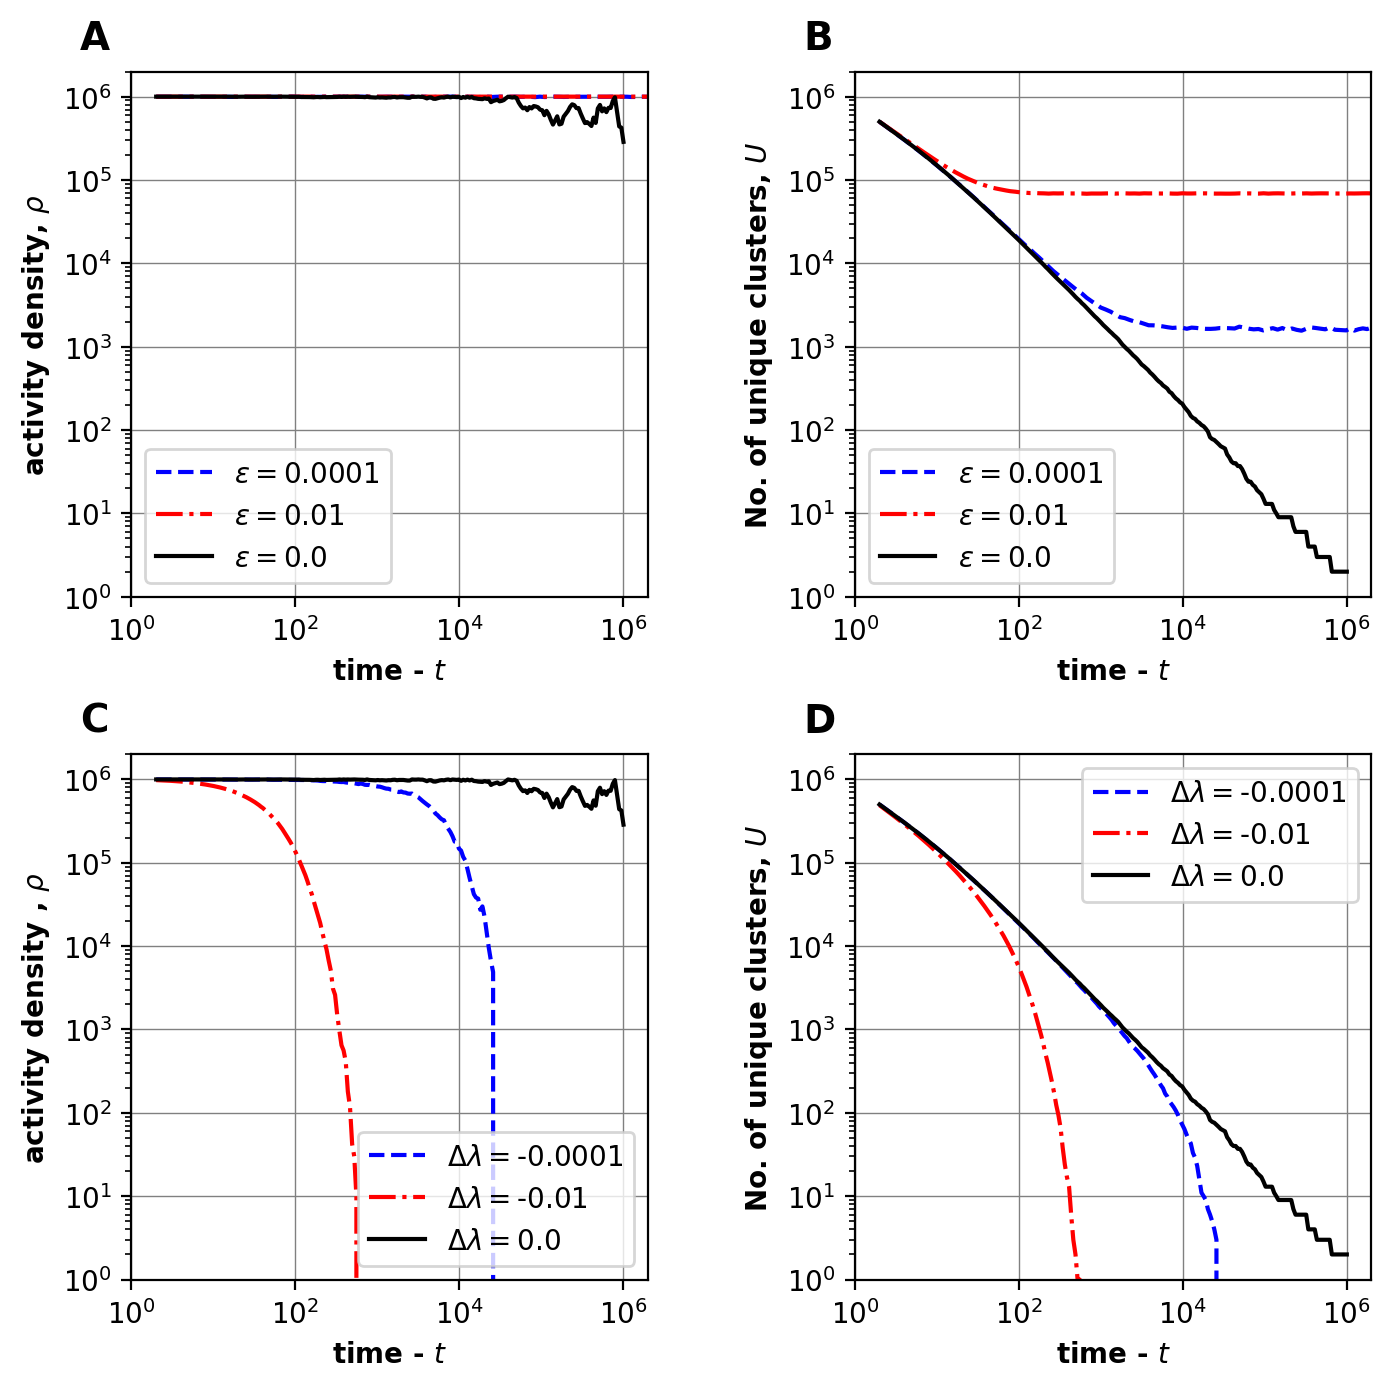

In [69]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1

fig = plt.figure(figsize=(8,8)); grid = gridspec.GridSpec(2,2,wspace=0.4,hspace=0.3)

ax1 = fig.add_subplot(grid[0,0]) # Unique Clusters vs. Time (Eps)
ax2 = fig.add_subplot(grid[0,1]) # avg Cluster Size vs. Time (Eps)
ax3 = fig.add_subplot(grid[1,0]) # Unique Clusters vs. Time (Delta)
ax4 = fig.add_subplot(grid[1,1]) # avg Cluster Size vs. Time (Delta)

color_list = ['blue','red','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [10,18]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax1.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax2.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
cp = -1
plotSeeds= [86, 88]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax3.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)
ax1.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax2.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax3.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax4.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax1.set_xlim(left=1,right=2 * 10e5); ax1.set_ylim(bottom=1,top=2 * 10e5)
ax2.set_xlim(left=1,right=2 * 10e5); ax2.set_ylim(bottom=1,top=2 * 10e5)
ax3.set_xlim(left=1,right=2 * 10e5); ax3.set_ylim(bottom=1,top=2 * 10e5)
ax4.set_xlim(left=1,right=2 * 10e5); ax4.set_ylim(bottom=1,top=2 * 10e5)

ax1.text(-0.1, 1.1, 'A', fontsize=14, fontweight='bold', va='top', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'B', fontsize=14, fontweight='bold', va='top', transform=ax2.transAxes)
ax3.text(-0.1, 1.1, 'C', fontsize=14, fontweight='bold', va='top', transform=ax3.transAxes)
ax4.text(-0.1, 1.1, 'D', fontsize=14, fontweight='bold', va='top', transform=ax4.transAxes)
    
ax1.set_xlabel(r'time - $t$',fontweight='bold')
ax1.set_ylabel(r'activity density, $\rho$',fontweight='bold')
ax2.set_xlabel(r'time - $t$',fontweight='bold')
ax2.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')
ax3.set_xlabel(r'time - $t$',fontweight='bold')
ax3.set_ylabel(r'activity density , $\rho$',fontweight='bold')
ax4.set_xlabel(r'time - $t$',fontweight='bold')
ax4.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')

ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax1.legend();
ax2.legend();
ax3.legend(); 
ax4.legend();

ax1.grid(linestyle='-', linewidth='0.5', color='grey')
ax2.grid(linestyle='-', linewidth='0.5', color='grey')
ax3.grid(linestyle='-', linewidth='0.5', color='grey')
ax4.grid(linestyle='-', linewidth='0.5', color='grey')


fig.savefig('Plots/alpha_Relax.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

## !!! This is the $\alpha$ figure for the Paper!!!

brain_1xx/brain106_timeData.txt
brain_1xx/brain110_timeData.txt
brain_1xx/brain114_timeData.txt
brain_2xx/brain285_timeData.txt
brain_2xx/brain286_timeData.txt
brain_2xx/brain287_timeData.txt
brain_2xx/brain290_timeData.txt
Adding plot elements
Adding labels
Changing scale
Adding legend
Adding gridlines
Removing ticks
Showing Fig


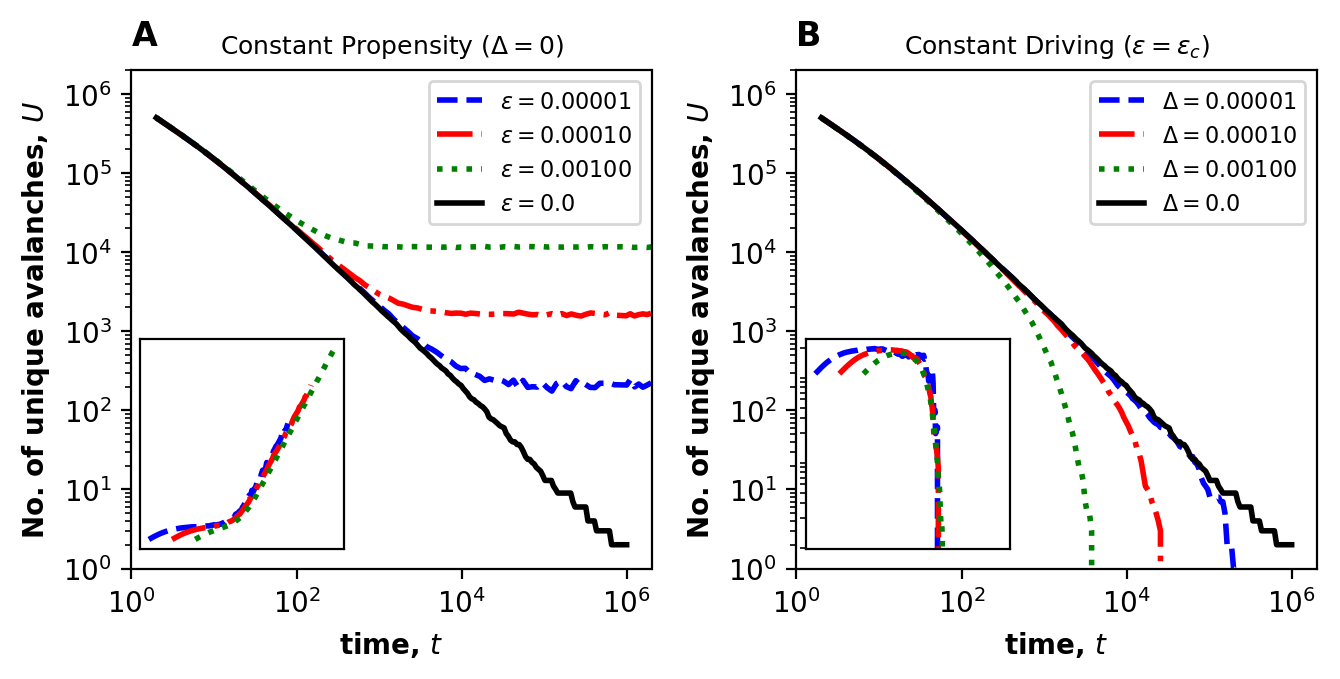

In [48]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8,3.5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.11, 0.2, 0.15, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.6, 0.2, 0.15, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])

ax1.text( x=-0.00, y=1.05, s="A", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax1.transAxes)  # Note the Font Size
ax2.text( x=-0.00, y=1.05, s="B", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax2.transAxes)  # Note the Fontsize


color_list = ['blue','red','green','black']
line_list = ['--','-.',':','-']
cp = -1

plotSeeds= [6,10,14]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax3.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,2]*activityDensity[:,0], 
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)), 
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax1.plot(activityDensity[:,0],activityDensity[:,2],
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])

cp = -1
plotSeeds= [85, 86, 87]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax4.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])), activityDensity[:,2]*activityDensity[:,0],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax2.plot(activityDensity[:,0],activityDensity[:,2],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)

ax1.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])
ax2.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\Delta =$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])

print('Adding plot elements')

ax1.set_xlim(left=1,right=2 * 1e6); ax1.set_ylim(bottom=1,top=2 * 1e6)
ax2.set_xlim(left=1,right=2 * 1e6); ax2.set_ylim(bottom=1,top=2 * 1e6)

print('Adding labels')
ax1.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'No. of unique avalanches, $U$',fontweight = 'bold', fontsize = fs )
ax2.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax2.set_ylabel(r'No. of unique avalanches, $U$',fontweight = 'bold', fontsize = fs )


print('Changing scale')
ax1.set_yscale('log', nonposy='clip') 
ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip') 
ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip') 
ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip') 
ax4.set_xscale('log', nonposx='clip')

print('Adding legend')
ax1.legend(fontsize=8,loc=1);
ax2.legend(fontsize=8,loc=1);

print('Adding gridlines')
# ax1.grid(True)
# ax2.grid(True)
# ax3.grid(True)
# ax4.grid(True)

print('Removing ticks')
ax3.tick_params(right= False,top= False,left= False, bottom= False)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax4.tick_params(right= False,top= False,left= False, bottom= False)
ax4.set_yticklabels([])
ax4.set_xticklabels([])

ax1.set_title('Constant Propensity ($\Delta = 0$)',fontsize=fs-1 )# Note the Font Size
ax2.set_title('Constant Driving ($\epsilon = \epsilon_c$)',fontsize=fs-1 )# Note the Font Size

print('Showing Fig')
fig.savefig('Plots/alpha.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

brain106_timeData.txt
brain110_timeData.txt
brain114_timeData.txt
brain285_timeData.txt
brain286_timeData.txt
brain287_timeData.txt
brain290_timeData.txt
Adding plot elements
Adding labels
Changing scale
Adding legend
Adding gridlines
Removing ticks
Showing Fig


/Library/Python/3.7/site-packages/ipykernel_launcher.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Library/Python/3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


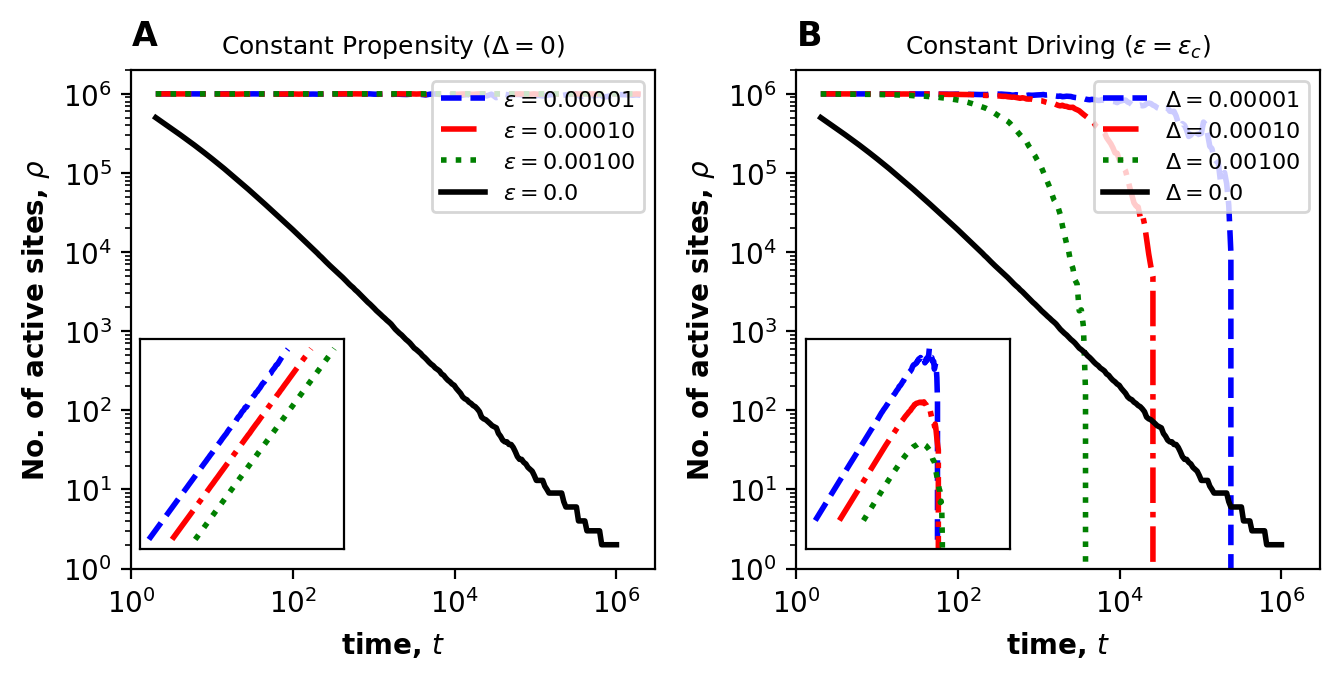

In [22]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1

fs = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8,3.5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.11, 0.2, 0.15, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.6, 0.2, 0.15, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])

ax1.text( x=-0.00, y=1.05, s="A", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax1.transAxes)  # Note the Font Size
ax2.text( x=-0.00, y=1.05, s="B", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax2.transAxes)  # Note the Fontsize


color_list = ['blue','red','green','black']
line_list = ['--','-.',':','-']
cp = -1

plotSeeds= [6,10,14]
for i in plotSeeds:
    cp +=1
    timeString = 'brain1' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax3.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,1]*activityDensity[:,0], 
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)), 
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax1.plot(activityDensity[:,0],activityDensity[:,1],
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])

cp = -1
plotSeeds= [85, 86, 87]
for i in plotSeeds:
    cp +=1
    timeString = 'brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax4.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])), activityDensity[:,1]*activityDensity[:,0],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax2.plot(activityDensity[:,0],activityDensity[:,1],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
savename = 'brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)

ax1.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])
ax2.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\Delta =$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])

print('Adding plot elements')

ax1.set_xlim(left=1,right=3 * 1e6); ax1.set_ylim(bottom=1,top=2 * 1e6)
ax2.set_xlim(left=1,right=3 * 1e6); ax2.set_ylim(bottom=1,top=2 * 1e6)

print('Adding labels')
ax1.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'No. of active sites, $\rho$',fontweight = 'bold', fontsize = fs )
ax2.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax2.set_ylabel(r'No. of active sites, $\rho$',fontweight = 'bold', fontsize = fs )


print('Changing scale')
ax1.set_yscale('log', nonposy='clip') 
ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip') 
ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip') 
ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip') 
ax4.set_xscale('log', nonposx='clip')

print('Adding legend')
ax1.legend(fontsize=8,loc=1);
ax2.legend(fontsize=8,loc=1);

print('Adding gridlines')
# ax1.grid(True)
# ax2.grid(True)
# ax3.grid(True)
# ax4.grid(True)

print('Removing ticks')
ax3.tick_params(right= False,top= False,left= False, bottom= False)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax4.tick_params(right= False,top= False,left= False, bottom= False)
ax4.set_yticklabels([])
ax4.set_xticklabels([])

ax1.set_title('Constant Propensity ($\Delta = 0$)',fontsize=fs-1 )# Note the Font Size
ax2.set_title('Constant Driving ($\epsilon = \epsilon_c$)',fontsize=fs-1 )# Note the Font Size

print('Showing Fig')
fig.savefig('alpha_rho.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

Text(-0.1, 1.1, 'B')

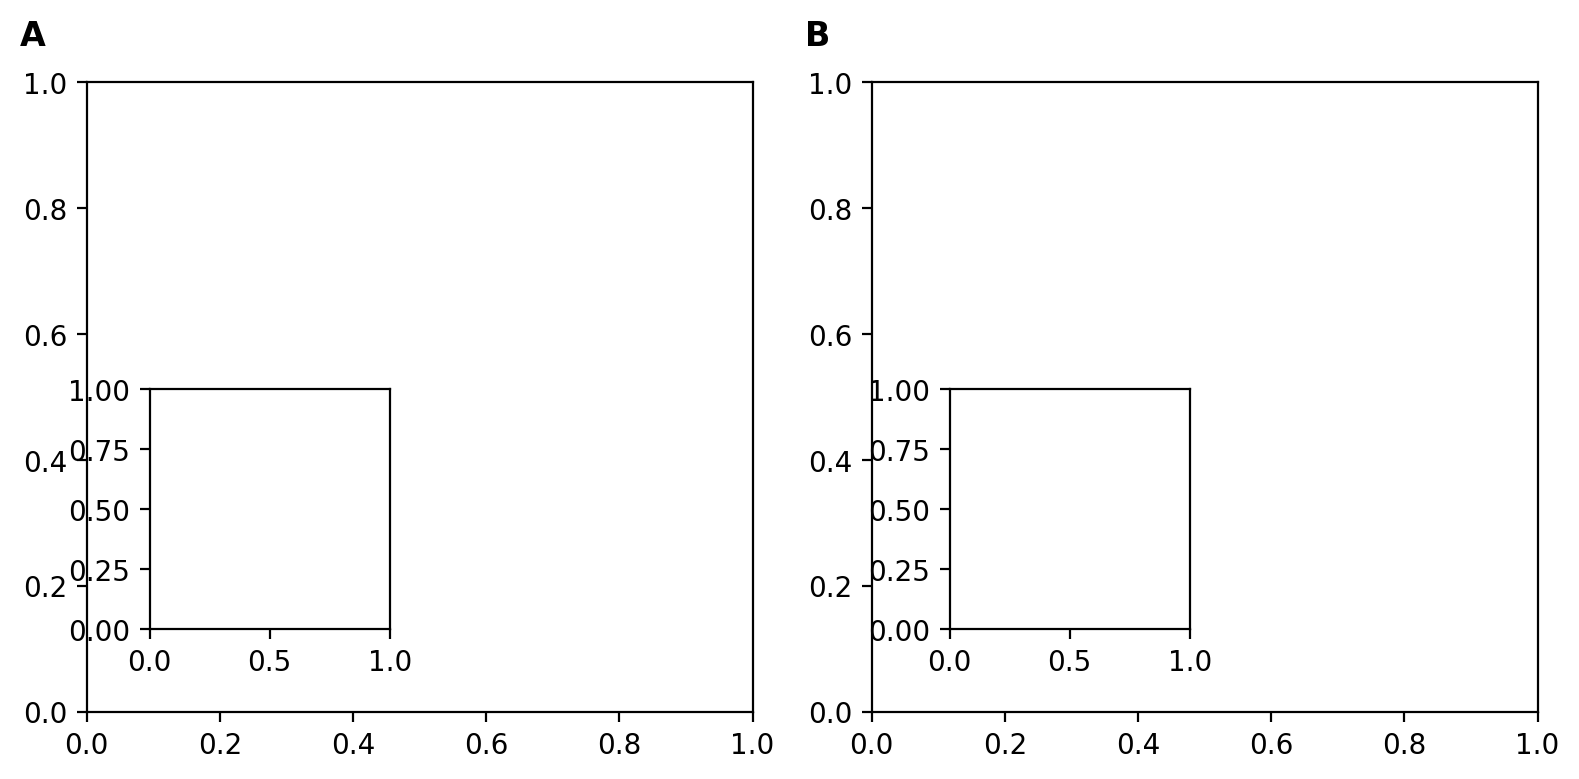

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.1, 0.2, 0.15, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.6, 0.2, 0.15, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])

ax1.text(-0.1, 1.1, 'A', fontsize=12, fontweight='bold', va='top')
ax2.text(-0.1, 1.1, 'B', fontsize=12, fontweight='bold', va='top')

starting i=2
starting i=10
starting i=18
starting i=84
starting i=86
starting i=88


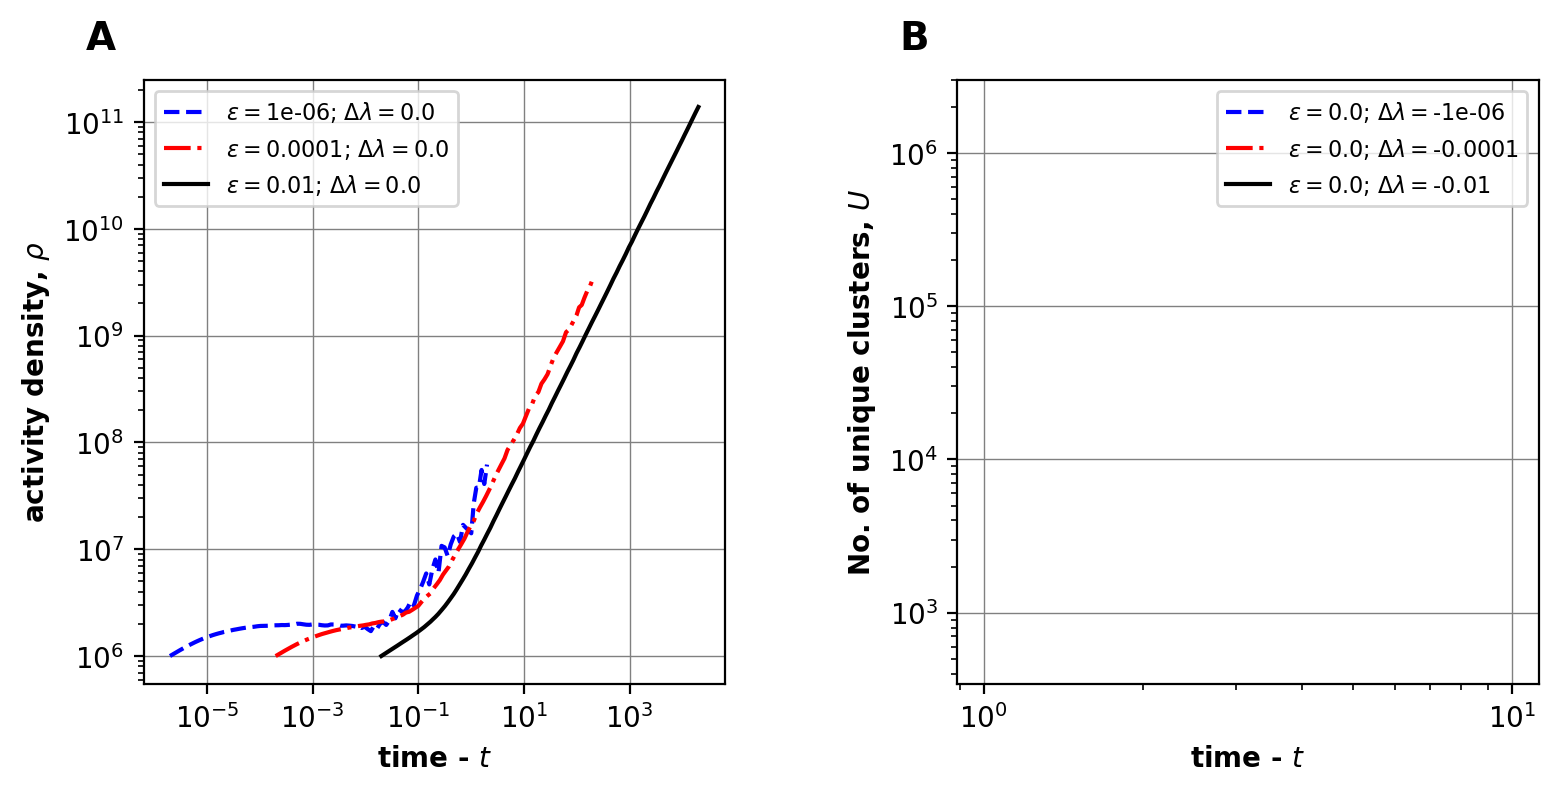

In [112]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1

fig = plt.figure(figsize=(9,4)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.3)

ax1 = fig.add_subplot(grid[0,0]) # Unique Clusters vs. Time (Eps)
ax2 = fig.add_subplot(grid[0,1]) # avg Cluster Size vs. Time (Eps)

color_list = ['blue','red','green','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [2,10,18]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax1.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,2]*activityDensity[:,0], label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

cp = -1
plotSeeds= [84, 86, 88]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax2.plot(activityDensity[:,0]* (float(parts[2])-float(parts[3])), activityDensity[:,2]*activityDensity[:,0],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)

# ax1.plot(activityDensity[:,0] * 0,activityDensity[:,0] * activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
#          linewidth=1.5,color='grey',linestyle=line_list[cp])
# ax2.plot(activityDensity[:,0] * 0,activityDensity[:,0] * activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
#          linewidth=1.5,color='grey',linestyle=line_list[cp])

# ax1.set_xlim(left=1,right=2 * 10e5); ax1.set_ylim(bottom=1,top=2 * 10e5)
# ax2.set_xlim(left=1,right=2 * 10e5); ax2.set_ylim(bottom=1,top=2 * 10e5)

ax1.text(-0.1, 1.1, 'A', fontsize=14, fontweight='bold', va='top', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'B', fontsize=14, fontweight='bold', va='top', transform=ax2.transAxes)
    
ax1.set_xlabel(r'time - $t$',fontweight='bold')
ax1.set_ylabel(r'activity density, $\rho$',fontweight='bold')
ax2.set_xlabel(r'time - $t$',fontweight='bold')
ax2.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')

ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')

ax1.legend(fontsize=8);
ax2.legend(fontsize=8);

ax1.grid(linestyle='-', linewidth='0.5', color='grey')
ax2.grid(linestyle='-', linewidth='0.5', color='grey')

# fig.savefig('Plots/alpha_Relax.png',dpi=300,bbox_inches = "tight")
plt.show(fig)